#NBEATS+RevIN - Akshtit Mahendru - akshitmahendru15@gmail.com

In [1]:
# Importing and formatting data with Python
import csv
import os
from datetime import datetime
from pathlib import Path
from tqdm import tqdm
import pandas as pd


basepath = Path('dataset50/')

dataset50 = {}

for csvfile in os.listdir(basepath):
    temp = str(csvfile)
    temp_loc = os.path.join(basepath,csvfile)
    if temp_loc == 'dataset50/.ipynb_checkpoints':
        continue
    dataset50[temp[:-4]] = pd.read_csv(temp_loc)
for key in dataset50:
    dataset50[key].columns = ['Index', 'value', 'timestamp']
for key in dataset50:
    dataset50[key] = dataset50[key].drop(['Index'], axis = 1)
for key in dataset50:
    dataset50[key].timestamp = pd.to_datetime(dataset50[key].timestamp, unit="s")
for key in dataset50:
    col_list = list(dataset50[key].columns)
    x, y = col_list.index("value"), col_list.index("timestamp")
    col_list[y], col_list[x] = col_list[x], col_list[y]
    dataset50[key] = dataset50[key].set_index('timestamp')



In [3]:
import tensorflow as tf

In [5]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [6]:
def make_preds(model, input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [7]:
class ReVIN_normalization(tf.keras.layers.Layer):
    def __init__(self, noise, **kwargs):
        super().__init__(**kwargs)
        self.noise = noise
        self.gamma = tf.Variable(initial_value = 0.1, trainable = True)
        self.beta = tf.Variable(initial_value = 0.1, trainable = True)
        
    
    def call(self,inputs):
        self.mean = tf.math.reduce_mean(inputs)
        self.variance = tf.math.reduce_variance(inputs)
        x = inputs
        x = (x - self.mean)/tf.math.sqrt(self.variance + self.noise)
        #for i in x:
         #   i = (i - self.mean)/tf.math.sqrt(self.variance+self.noise)
        transformed = self.gamma*x + self.beta
        #The below array denorm_array will return the parameters to the denormalisation layer to use.
        denorm_array = [self.mean, self.variance, self.gamma, self.beta, self.noise]
        
        return transformed,  denorm_array

In [8]:
class ReVinDenormalize(tf.keras.layers.Layer):
    def __init__(self,**kwargs):
        super().__init__(**kwargs)

    def call(self, inputs):
        predictions, denorm_array = inputs
        mean = denorm_array[0]
        variance = denorm_array[1]
        gamma = denorm_array[2]
        beta = denorm_array[3]
        noise = denorm_array[4]
        retransformed = (predictions - beta)/gamma
        denormalized = mean + (retransformed*tf.math.sqrt(variance + noise))

        return denormalized

In [9]:
#NBEATS

In [10]:
# Create NBeatsBlock custom layer 
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called 
    x = inputs 
    for layer in self.hidden: # pass inputs through each hidden layer 
      x = layer(x)
    theta = self.theta_layer(x) 
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [11]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
    ensemble_preds = []
    for model in ensemble_models:
        preds = model.predict(data) # make predictions with current ensemble model
        ensemble_preds.append(preds)
    return tf.constant(tf.squeeze(ensemble_preds))

In [12]:
from tensorflow.keras.layers import Dense,Input,Dense, LSTM
from tensorflow.keras import Model

In [13]:
from tensorflow.keras import layers
from tqdm import tqdm
def get_ensemble_models(key, num_iter=10, 
                        num_epochs=100, 
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For example, if num_iter=10, a list of 30 trained models will be returned:
  10 * len(["mae", "mse", "mape"]).
  """
  # Make empty list for trained ensemble models
  ensemble_models = []
  dataset50_models = {}
  df = dataset50[key]

  # Create num_iter number of models per loss function
  for i in tqdm(range(num_iter)):
    # Build and fit a new model with a different loss function
    for loss_function in tqdm(loss_fns):

      HORIZON = 1 # how far to predict forward
      WINDOW_SIZE = 8 # how far to lookback
      # Add windowed columns
      df_nbeats = df.copy()
      for win_size in tqdm(range(WINDOW_SIZE)):
        df_nbeats[f"value+{win_size+1}"] = df_nbeats["value"].shift(periods=win_size+1)
      df_nbeats.head()
      # Make features and labels
      X = df_nbeats.dropna().drop("value", axis=1)
      y = df_nbeats.dropna()["value"]
      # Make train and test sets
      split_size = int(len(X) * 0.75)
      X_train, y_train = X[:split_size], y[:split_size]
      X_test, y_test = X[split_size:], y[split_size:]
      
      # 1. Turn train and test arrays into tensor Datasets
      train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
      train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)
      test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
      test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)
      
      # 2. Combine features & labels
      train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
      test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))
      
      # 3. Batch and prefetch for optimal performance
      BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
      train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
      test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
      # Values from N-BEATS paper Figure 1 and Table 18/Appendix D
      N_EPOCHS = 5000 # called "Iterations" in Table 18
      N_NEURONS = 512 # called "Width" in Table 18
      N_LAYERS = 4
      N_STACKS = 30
      INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
      THETA_SIZE = INPUT_SIZE + HORIZON

      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}, window size: 7")

      tf.keras.backend.clear_session()
      #input layer
      Input_layer = Input(shape = INPUT_SIZE)
      #initialising the revin layer
      revin_init = ReVIN_normalization(noise=0.01)
      #Revin layer which is connected to the input layer
      revin_layer, denorm_array = revin_init(Input_layer)

      # 1. Setup N-BEATS Block layer
      nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                       theta_size=THETA_SIZE,
                                       horizon=HORIZON,
                                       n_neurons=N_NEURONS,
                                       n_layers=N_LAYERS,
                                       name="InitialBlock")




      # 2. Create input to stacks
      #stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")
      # 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
      backcast, forecast = nbeats_block_layer(Input_layer)
      # Add in subtraction residual link,
      residuals = tf.keras.layers.subtract([revin_layer, backcast], name=f"subtract_00") 
      # 4. Create stacks of blocks
      for i, _ in enumerate(range(N_STACKS-1)): 
        # first stack is already creted in (3)
        # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
        backcast, block_forecast = NBeatsBlock(
            input_size=INPUT_SIZE,
            theta_size=THETA_SIZE,
            horizon=HORIZON,
            n_neurons=N_NEURONS,
            n_layers=N_LAYERS,
            name=f"NBeatsBlock_{i}"
            )(residuals) # pass it in residuals (the backcast)
          # 6. Create the double residual stacking
        residuals = tf.keras.layers.subtract([residuals, backcast], name=f"subtract_{i}") 
        forecast = tf.keras.layers.add([forecast, block_forecast], name=f"add_{i}")
      denorm_init = ReVinDenormalize()
      denorm_layer = denorm_init([forecast, denorm_array])
      # 7. Put the stack model together
      model = tf.keras.Model(inputs=Input_layer, 
                               outputs=denorm_layer, 
                               name="model_N-BEATS")
      # 8. Compile with MAE loss and Adam optimizer
      model.compile(loss="mae",
                      optimizer=tf.keras.optimizers.Adam(0.001),
                      metrics=["mae", "mse"])
    
      # 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
      model.fit(train_dataset,
                epochs=N_EPOCHS,
                validation_data=test_dataset,
                verbose=0, # prevent large amounts of training outputs
                # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])
    
      # Append fitted model to list of ensemble models
      ensemble_models.append(model)
  return ensemble_models

In [28]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 8 # how far to lookback
# Add windowed columns
df_nbeats = dataset50['0'].copy()
for win_size in range(WINDOW_SIZE):
    df_nbeats[f"value+{win_size+1}"] = df_nbeats["value"].shift(periods=win_size+1)


In [29]:
# Make features and labels
X = df_nbeats.dropna().drop("value", axis=1)
y = df_nbeats.dropna()["value"]
_
# Make train and test sets
split_size = int(len(X) * 0.75)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(624, 624, 208, 208)

In [30]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [31]:
# Get list of trained ensemble models
model_0 = get_ensemble_models(key = '0', num_iter=5, num_epochs=1000)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 2490.68it/s]


Optimizing model by reducing: mae for 1000 epochs, model number: 0, window size: 7

Epoch 232: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 725: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1205: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1305: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 1405: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 1505: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.



 33%|███▎      | 1/3 [01:29<02:58, 89.15s/it]

100%|██████████| 8/8 [00:00<00:00, 2386.69it/s]


Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7

Epoch 324: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 706: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 975: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1099: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 1199: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



 67%|██████▋   | 2/3 [02:39<01:18, 78.17s/it]

100%|██████████| 8/8 [00:00<00:00, 2584.29it/s]


Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7

Epoch 222: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 628: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1003: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1103: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 1203: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 2625.34it/s]


Optimizing model by reducing: mae for 1000 epochs, model number: 1, window size: 7

Epoch 565: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 1370: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1500: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1600: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 1700: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



 33%|███▎      | 1/3 [01:34<03:08, 94.45s/it]

100%|██████████| 8/8 [00:00<00:00, 2315.06it/s]


Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7

Epoch 543: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 786: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 999: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1099: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 1199: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



 67%|██████▋   | 2/3 [02:39<01:17, 77.08s/it]

100%|██████████| 8/8 [00:00<00:00, 2312.50it/s]


Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7

Epoch 441: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 1091: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1202: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1303: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 1403: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 2570.63it/s]


Optimizing model by reducing: mae for 1000 epochs, model number: 2, window size: 7

Epoch 182: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 492: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1846: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1950: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 2050: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



 33%|███▎      | 1/3 [02:06<04:12, 126.10s/it]

100%|██████████| 8/8 [00:00<00:00, 2686.07it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 362: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 596: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 768: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 960: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 1060: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



 67%|██████▋   | 2/3 [03:03<01:25, 85.50s/it] 

100%|██████████| 8/8 [00:00<00:00, 1674.21it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 474: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 928: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1058: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1158: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 1258: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 2552.83it/s]


Optimizing model by reducing: mae for 1000 epochs, model number: 3, window size: 7

Epoch 201: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 692: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 2072: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 2172: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 33%|███▎      | 1/3 [02:06<04:12, 126.11s/it]

100%|██████████| 8/8 [00:00<00:00, 2406.54it/s]


Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7

Epoch 194: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 495: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1588: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1688: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 1788: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



 67%|██████▋   | 2/3 [03:53<01:54, 114.87s/it]

100%|██████████| 8/8 [00:00<00:00, 2493.83it/s]


Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7

Epoch 358: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 829: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1360: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1475: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 1575: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 1668.88it/s]


Optimizing model by reducing: mae for 1000 epochs, model number: 4, window size: 7

Epoch 405: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 867: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1049: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1149: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 1249: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



 33%|███▎      | 1/3 [01:17<02:34, 77.40s/it]

100%|██████████| 8/8 [00:00<00:00, 2500.89it/s]


Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7

Epoch 285: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 619: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1283: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1442: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 1542: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 1642: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.



 67%|██████▋   | 2/3 [02:48<01:25, 85.56s/it]

100%|██████████| 8/8 [00:00<00:00, 2382.62it/s]


Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7

Epoch 323: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 710: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 849: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 949: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 1049: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



100%|██████████| 5/5 [21:45<00:00, 261.07s/it]


In [32]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=model_0,
                                     data=test_dataset)
ensemble_preds

1/1 [==============================] - 1s 825ms/step


<tf.Tensor: shape=(15, 208), dtype=float32, numpy=
array([[47.805424, 47.821934, 47.83484 , ..., 47.949554, 47.94242 ,
        47.948353],
       [47.80643 , 47.823505, 47.836388, ..., 47.952408, 47.941547,
        47.95128 ],
       [47.804836, 47.822983, 47.83613 , ..., 47.953335, 47.942455,
        47.95095 ],
       ...,
       [47.80528 , 47.820625, 47.83386 , ..., 47.949677, 47.94425 ,
        47.945793],
       [47.80532 , 47.820724, 47.832634, ..., 47.951813, 47.945965,
        47.946293],
       [47.80412 , 47.821533, 47.83465 , ..., 47.950577, 47.941944,
        47.94822 ]], dtype=float32)>

In [33]:
import numpy as np
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

{'mae': 0.00859631,
 'mse': 0.00012589259,
 'rmse': 0.011220187,
 'mape': 0.017939832,
 'mase': 0.97986066}

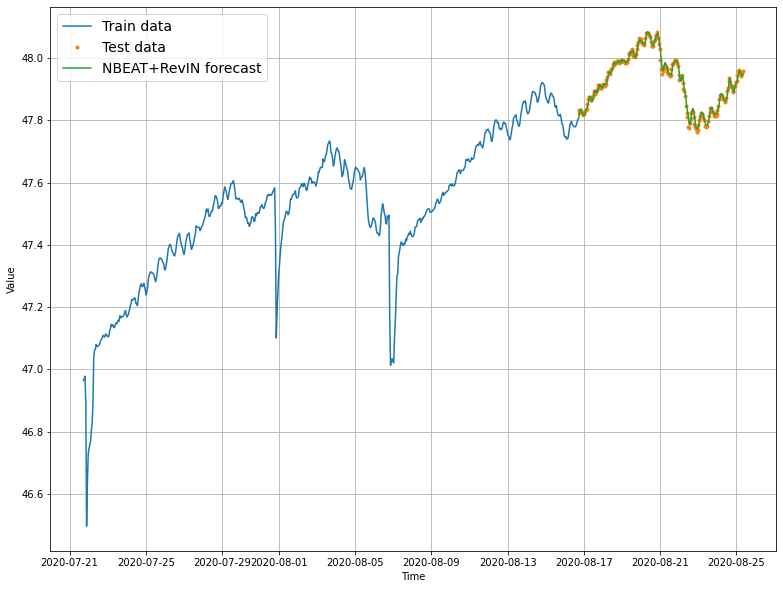

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
ensemble_median = np.median(ensemble_preds, axis=0)
offset = 0 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_train.index[offset:], values=y_train[offset:], label="Train data")
plot_time_series(timesteps=X_test.index[offset:], values=y_test[offset:], format = '.', start=offset, label="Test data")
plot_time_series(timesteps=X_test.index[offset:], values=ensemble_median[offset:], start=offset, label="NBEAT+RevIN forecast");

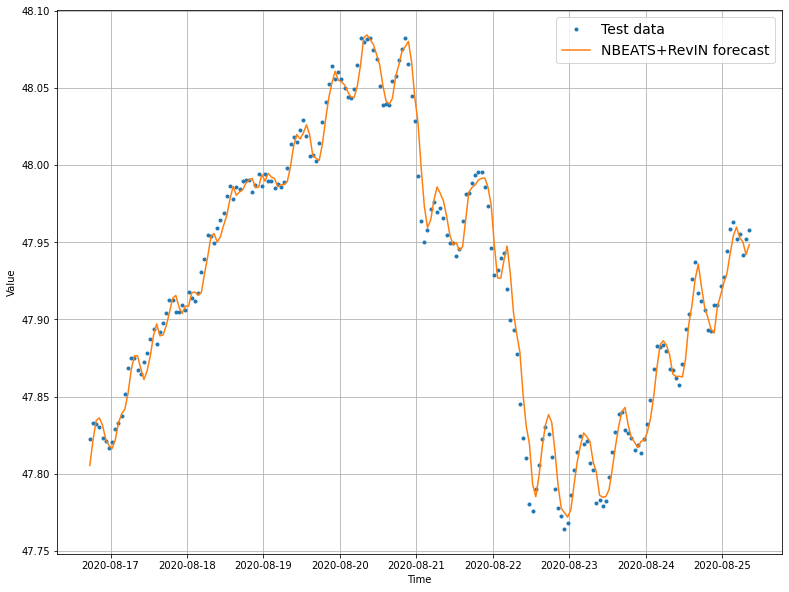

In [35]:
plt.figure(figsize=(13, 10))
offset = 0 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_test.index[offset:], values=y_test[offset:], format = ".", start=offset, label="Test data")
plot_time_series(timesteps=X_test.index[offset:], values=ensemble_median[offset:], format="-", start=offset, label="NBEATS+RevIN forecast");

In [50]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 8 # how far to lookback
# Add windowed columns
df_nbeats = dataset50['1'].copy()
for win_size in range(WINDOW_SIZE):
    df_nbeats[f"value+{win_size+1}"] = df_nbeats["value"].shift(periods=win_size+1)


In [51]:
# Make features and labels
X = df_nbeats.dropna().drop("value", axis=1)
y = df_nbeats.dropna()["value"]
_
# Make train and test sets
split_size = int(len(X) * 0.75)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(624, 624, 208, 208)

In [53]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [54]:
# Get list of trained ensemble models
model_1 = get_ensemble_models(key = '1', num_iter=5, num_epochs=1000)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 2270.87it/s]


Optimizing model by reducing: mae for 1000 epochs, model number: 0, window size: 7

Epoch 271: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 778: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 881: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 981: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 1081: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



 33%|███▎      | 1/3 [01:05<02:11, 65.98s/it]

100%|██████████| 8/8 [00:00<00:00, 1712.05it/s]


Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7

Epoch 201: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 729: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 829: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 929: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 67%|██████▋   | 2/3 [02:00<00:58, 58.96s/it]

100%|██████████| 8/8 [00:00<00:00, 2347.45it/s]


Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7

Epoch 160: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 635: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 735: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 2350.57it/s]


Optimizing model by reducing: mae for 1000 epochs, model number: 1, window size: 7

Epoch 213: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 782: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 891: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 991: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 33%|███▎      | 1/3 [00:54<01:48, 54.41s/it]

100%|██████████| 8/8 [00:00<00:00, 2378.23it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 187: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 712: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 812: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 912: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 67%|██████▋   | 2/3 [01:47<00:53, 53.41s/it]

100%|██████████| 8/8 [00:00<00:00, 2792.25it/s]


Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7

Epoch 268: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 809: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 909: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1009: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 2638.13it/s]


Optimizing model by reducing: mae for 1000 epochs, model number: 2, window size: 7

Epoch 214: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 562: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 705: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 805: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 905: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



 33%|███▎      | 1/3 [00:56<01:52, 56.16s/it]

100%|██████████| 8/8 [00:00<00:00, 2657.99it/s]


Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7

Epoch 175: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 544: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 644: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 744: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 67%|██████▋   | 2/3 [01:48<00:53, 53.88s/it]

100%|██████████| 8/8 [00:00<00:00, 2387.71it/s]


Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7

Epoch 149: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 686: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 786: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 886: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 2619.80it/s]


Optimizing model by reducing: mae for 1000 epochs, model number: 3, window size: 7

Epoch 314: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 1011: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1111: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



 33%|███▎      | 1/3 [01:20<02:41, 80.70s/it]

100%|██████████| 8/8 [00:00<00:00, 2528.40it/s]


Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7

Epoch 227: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 751: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 860: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 960: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 67%|██████▋   | 2/3 [02:19<01:08, 68.03s/it]

100%|██████████| 8/8 [00:00<00:00, 2481.84it/s]


Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7

Epoch 389: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 924: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1024: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 2481.29it/s]


Optimizing model by reducing: mae for 1000 epochs, model number: 4, window size: 7

Epoch 391: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 491: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.



 33%|███▎      | 1/3 [00:28<00:56, 28.23s/it]

100%|██████████| 8/8 [00:00<00:00, 2518.72it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 301: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 861: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 963: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1063: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 67%|██████▋   | 2/3 [01:43<00:55, 55.65s/it]

100%|██████████| 8/8 [00:00<00:00, 2226.13it/s]


Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7

Epoch 278: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 906: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1006: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



100%|██████████| 5/5 [14:13<00:00, 170.79s/it]


In [58]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=model_1,
                                     data=test_dataset)
ensemble_preds

1/1 [==============================] - 1s 790ms/step


<tf.Tensor: shape=(15, 208), dtype=float32, numpy=
array([[45.407078, 45.411694, 45.410908, ..., 43.92935 , 43.930557,
        43.93437 ],
       [45.42105 , 45.424248, 45.42542 , ..., 43.91425 , 43.919243,
        43.923397],
       [45.401432, 45.405052, 45.406208, ..., 43.921803, 43.924965,
        43.9244  ],
       ...,
       [45.408783, 45.409542, 45.414577, ..., 43.9246  , 43.921047,
        43.930504],
       [45.4176  , 45.412758, 45.415188, ..., 43.916637, 43.918983,
        43.924587],
       [45.410347, 45.411728, 45.411674, ..., 43.934475, 43.93775 ,
        43.943295]], dtype=float32)>

In [59]:
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

{'mae': 0.03162775,
 'mse': 0.0243611,
 'rmse': 0.15608042,
 'mape': 0.07199581,
 'mase': 1.2107365}

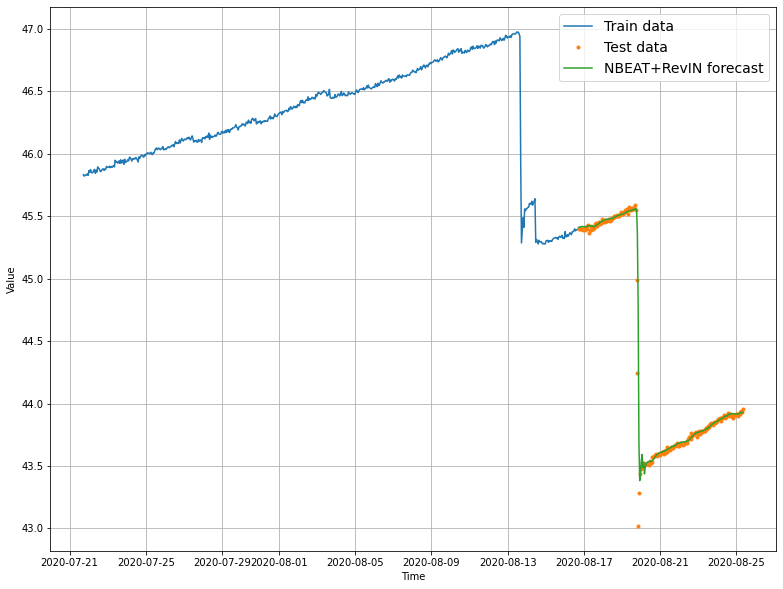

In [60]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
ensemble_median = np.median(ensemble_preds, axis=0)
offset = 0 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_train.index[offset:], values=y_train[offset:], label="Train data")
plot_time_series(timesteps=X_test.index[offset:], values=y_test[offset:], format = '.', start=offset, label="Test data")
plot_time_series(timesteps=X_test.index[offset:], values=ensemble_median[offset:], start=offset, label="NBEAT+RevIN forecast");

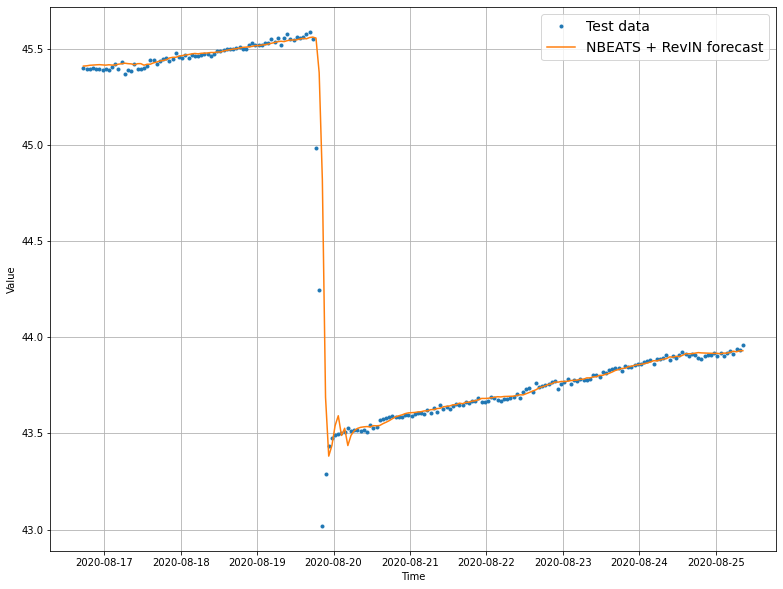

In [63]:
plt.figure(figsize=(13, 10))
offset = 0 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_test.index[offset:], values=y_test[offset:], format = ".", start=offset, label="Test data")
plot_time_series(timesteps=X_test.index[offset:], values=ensemble_median[offset:], format="-", start=offset, label="NBEATS + RevIN forecast");

In [15]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 8 # how far to lookback
# Add windowed columns
df_nbeats = dataset50['2'].copy()
for win_size in range(WINDOW_SIZE):
    df_nbeats[f"value+{win_size+1}"] = df_nbeats["value"].shift(periods=win_size+1)
# Make features and labels
X = df_nbeats.dropna().drop("value", axis=1)
y = df_nbeats.dropna()["value"]

# Make train and test sets
split_size = int(len(X) * 0.75)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
print(len(X_train), len(y_train), len(X_test), len(y_test))

# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

624 624 208 208


(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [16]:
# Get list of trained ensemble models
model_2 = get_ensemble_models(key = '2', num_iter=5, num_epochs=1000)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 2423.75it/s]


Optimizing model by reducing: mae for 1000 epochs, model number: 0, window size: 7

Epoch 261: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 1124: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1225: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1325: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 33%|███▎      | 1/3 [01:07<02:14, 67.38s/it]

100%|██████████| 8/8 [00:00<00:00, 2740.26it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 197: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 345: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 445: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



 67%|██████▋   | 2/3 [01:33<00:43, 43.21s/it]

100%|██████████| 8/8 [00:00<00:00, 2511.75it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 395: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 535: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 635: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 2591.08it/s]


Optimizing model by reducing: mae for 1000 epochs, model number: 1, window size: 7

Epoch 234: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 358: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 458: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



 33%|███▎      | 1/3 [00:27<00:54, 27.05s/it]

100%|██████████| 8/8 [00:00<00:00, 2797.14it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 415: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 558: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 658: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



 67%|██████▋   | 2/3 [01:03<00:32, 32.47s/it]

100%|██████████| 8/8 [00:00<00:00, 2602.13it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 248: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 1011: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1111: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 2615.11it/s]


Optimizing model by reducing: mae for 1000 epochs, model number: 2, window size: 7

Epoch 247: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 597: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 705: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 805: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 33%|███▎      | 1/3 [00:42<01:25, 43.00s/it]

100%|██████████| 8/8 [00:00<00:00, 2603.74it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 372: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 1087: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1187: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



 67%|██████▋   | 2/3 [01:40<00:51, 51.78s/it]

100%|██████████| 8/8 [00:00<00:00, 2604.75it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 356: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 524: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 624: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 2577.94it/s]

Optimizing model by reducing: mae for 1000 epochs, model number: 3, window size: 7



Epoch 381: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 513: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 613: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



 33%|███▎      | 1/3 [00:32<01:05, 32.88s/it]

100%|██████████| 8/8 [00:00<00:00, 2550.31it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 852: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 1401: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1501: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



 67%|██████▋   | 2/3 [01:45<00:56, 56.17s/it]

100%|██████████| 8/8 [00:00<00:00, 2275.03it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 359: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 483: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 583: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 2647.50it/s]

Optimizing model by reducing: mae for 1000 epochs, model number: 4, window size: 7



Epoch 305: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 791: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 893: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 993: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 33%|███▎      | 1/3 [00:50<01:40, 50.26s/it]

100%|██████████| 8/8 [00:00<00:00, 2467.24it/s]


Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7

Epoch 245: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 386: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 486: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



 67%|██████▋   | 2/3 [01:19<00:37, 37.80s/it]

100%|██████████| 8/8 [00:00<00:00, 2204.34it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 423: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 523: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.



100%|██████████| 5/5 [10:28<00:00, 125.74s/it]


In [17]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=model_2,
                                     data=test_dataset)
ensemble_preds

1/1 [==============================] - 1s 796ms/step


<tf.Tensor: shape=(15, 208), dtype=float32, numpy=
array([[45.40405 , 45.40262 , 45.405396, ..., 43.93405 , 43.937893,
        43.9413  ],
       [45.424046, 45.42599 , 45.430115, ..., 43.929054, 43.93077 ,
        43.935013],
       [45.415947, 45.420208, 45.420074, ..., 43.93369 , 43.939354,
        43.93959 ],
       ...,
       [45.395996, 45.40191 , 45.401474, ..., 43.925575, 43.935627,
        43.934563],
       [45.383877, 45.388523, 45.387424, ..., 43.93176 , 43.941696,
        43.937634],
       [45.39287 , 45.392376, 45.39462 , ..., 43.896114, 43.8969  ,
        43.902313]], dtype=float32)>

In [19]:
import numpy as np
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

{'mae': 0.029394241,
 'mse': 0.021217206,
 'rmse': 0.14566128,
 'mape': 0.06689647,
 'mase': 1.125236}

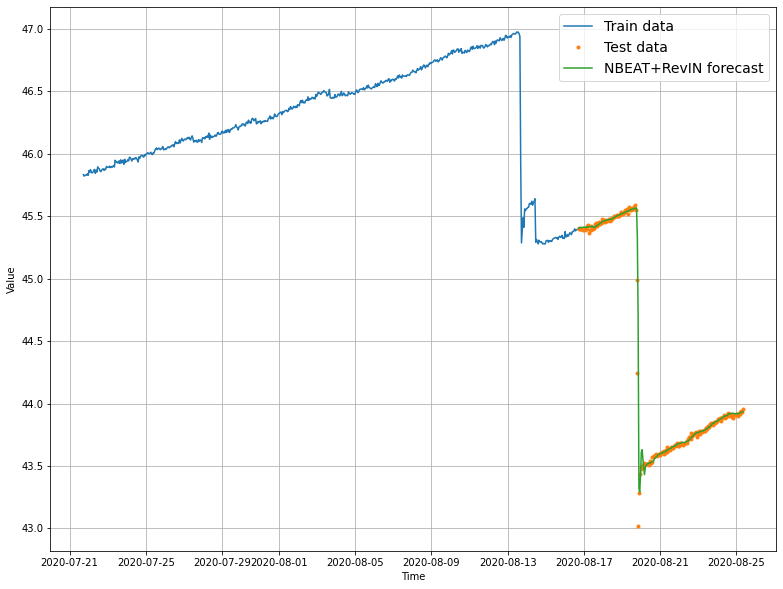

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
ensemble_median = np.median(ensemble_preds, axis=0)
offset = 0 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_train.index[offset:], values=y_train[offset:], label="Train data")
plot_time_series(timesteps=X_test.index[offset:], values=y_test[offset:], format = '.', start=offset, label="Test data")
plot_time_series(timesteps=X_test.index[offset:], values=ensemble_median[offset:], start=offset, label="NBEAT+RevIN forecast");

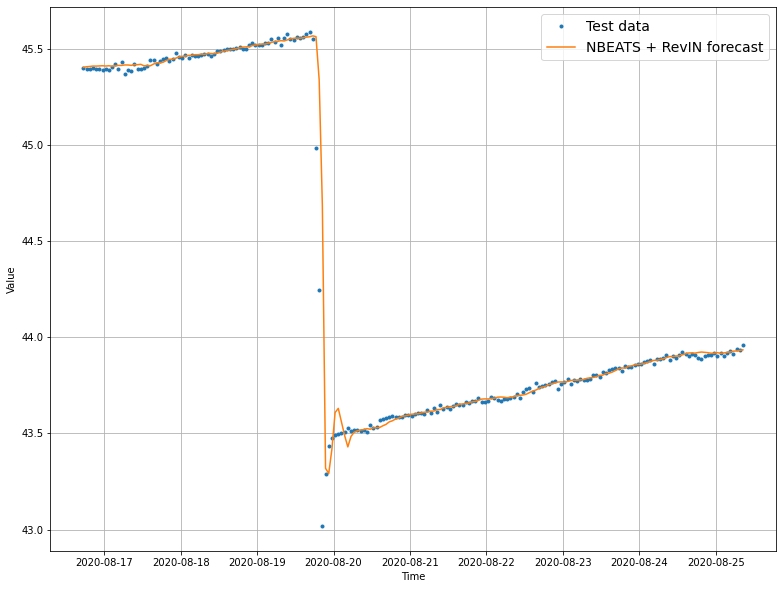

In [22]:
plt.figure(figsize=(13, 10))
offset = 0 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_test.index[offset:], values=y_test[offset:], format = ".", start=offset, label="Test data")
plot_time_series(timesteps=X_test.index[offset:], values=ensemble_median[offset:], format="-", start=offset, label="NBEATS + RevIN forecast");

In [ ]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 8 # how far to lookback
# Add windowed columns
df_nbeats = dataset50['3'].copy()
for win_size in range(WINDOW_SIZE):
    df_nbeats[f"value+{win_size+1}"] = df_nbeats["value"].shift(periods=win_size+1)
# Make features and labels
X = df_nbeats.dropna().drop("value", axis=1)
y = df_nbeats.dropna()["value"]

# Make train and test sets
split_size = int(len(X) * 0.75)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
print(len(X_train), len(y_train), len(X_test), len(y_test))

# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

624 624 208 208


(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [16]:
# Get list of trained ensemble models
model_3 = get_ensemble_models(key = '3', num_iter=5, num_epochs=1000)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 2827.78it/s]


Optimizing model by reducing: mae for 1000 epochs, model number: 0, window size: 7

Epoch 489: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 700: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1661: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1761: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 33%|███▎      | 1/3 [01:23<02:46, 83.10s/it]

100%|██████████| 8/8 [00:00<00:00, 2868.64it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 417: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 552: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1964: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 2064: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 67%|██████▋   | 2/3 [03:01<01:32, 92.02s/it]

100%|██████████| 8/8 [00:00<00:00, 2577.94it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 326: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 579: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 679: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 2394.69it/s]

Optimizing model by reducing: mae for 1000 epochs, model number: 1, window size: 7



Epoch 322: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 526: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1934: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 2067: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 2167: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



 33%|███▎      | 1/3 [01:42<03:24, 102.33s/it]

100%|██████████| 8/8 [00:00<00:00, 2444.59it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 297: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 580: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 3016: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 3178: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 3278: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



 67%|██████▋   | 2/3 [04:13<02:11, 131.07s/it]

100%|██████████| 8/8 [00:00<00:00, 2412.77it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 183: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 421: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 2649: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 2846: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 2946: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 2604.15it/s]

Optimizing model by reducing: mae for 1000 epochs, model number: 2, window size: 7



Epoch 151: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 258: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1476: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1763: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 1863: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



 33%|███▎      | 1/3 [01:41<03:22, 101.12s/it]

100%|██████████| 8/8 [00:00<00:00, 2671.53it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 113: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 381: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 481: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



 67%|██████▋   | 2/3 [02:08<00:57, 57.98s/it] 

100%|██████████| 8/8 [00:00<00:00, 2554.19it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 255: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 371: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1990: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 2204: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 2304: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 2674.30it/s]

Optimizing model by reducing: mae for 1000 epochs, model number: 3, window size: 7



Epoch 215: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 370: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1271: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1428: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 1528: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



 33%|███▎      | 1/3 [01:15<02:31, 75.80s/it]

100%|██████████| 8/8 [00:00<00:00, 2440.32it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 210: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 360: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1320: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1420: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 67%|██████▋   | 2/3 [02:24<01:11, 71.81s/it]

100%|██████████| 8/8 [00:00<00:00, 2679.42it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 213: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 334: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1415: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1515: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 2464.16it/s]

Optimizing model by reducing: mae for 1000 epochs, model number: 4, window size: 7



Epoch 431: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 1083: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1209: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1309: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 33%|███▎      | 1/3 [01:08<02:16, 68.48s/it]

100%|██████████| 8/8 [00:00<00:00, 2381.27it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 219: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 330: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1031: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1131: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 67%|██████▋   | 2/3 [02:07<01:02, 62.94s/it]

100%|██████████| 8/8 [00:00<00:00, 2500.33it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 221: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 453: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1913: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 2025: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 2125: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



100%|██████████| 5/5 [21:43<00:00, 260.74s/it]


In [17]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=model_3,
                                     data=test_dataset)
ensemble_preds

1/1 [==============================] - 1s 829ms/step


<tf.Tensor: shape=(15, 208), dtype=float32, numpy=
array([[3348.354 , 3320.8691, 3331.3787, ..., 3583.4749, 3564.918 ,
        3561.8555],
       [3356.633 , 3322.045 , 3300.8545, ..., 3556.7925, 3527.3533,
        3555.812 ],
       [3359.4243, 3319.429 , 3333.9365, ..., 3597.6174, 3560.052 ,
        3563.3362],
       ...,
       [3395.1907, 3334.9607, 3337.9238, ..., 3583.621 , 3561.5186,
        3529.3005],
       [3386.679 , 3353.5466, 3344.2593, ..., 3539.2407, 3607.712 ,
        3589.7686],
       [3341.2834, 3336.7651, 3345.0332, ..., 3544.168 , 3595.5776,
        3472.5667]], dtype=float32)>

In [19]:
import numpy as np
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

{'mae': 33.226906,
 'mse': 2176.4475,
 'rmse': 46.652412,
 'mape': 0.9671772,
 'mase': 0.8759156}

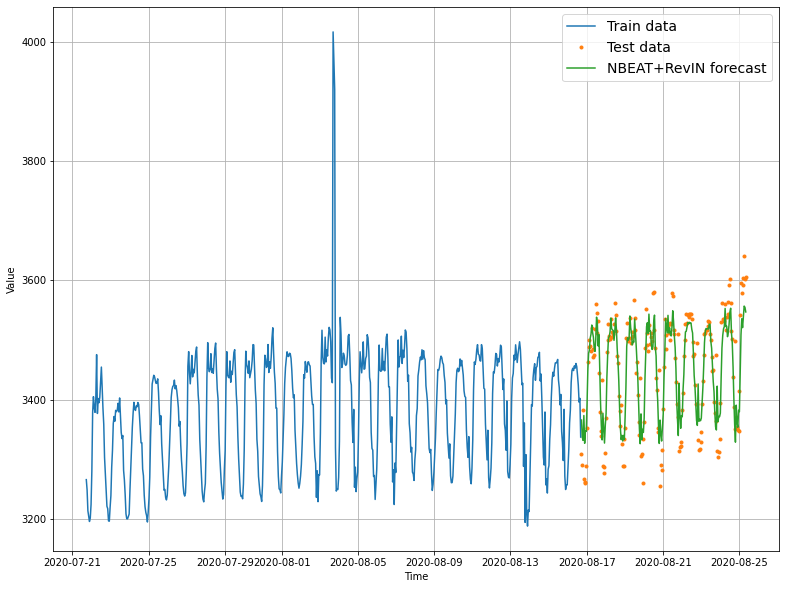

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
ensemble_median = np.median(ensemble_preds, axis=0)
offset = 0 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_train.index[offset:], values=y_train[offset:], label="Train data")
plot_time_series(timesteps=X_test.index[offset:], values=y_test[offset:], format = '.', start=offset, label="Test data")
plot_time_series(timesteps=X_test.index[offset:], values=ensemble_median[offset:], start=offset, label="NBEAT+RevIN forecast");

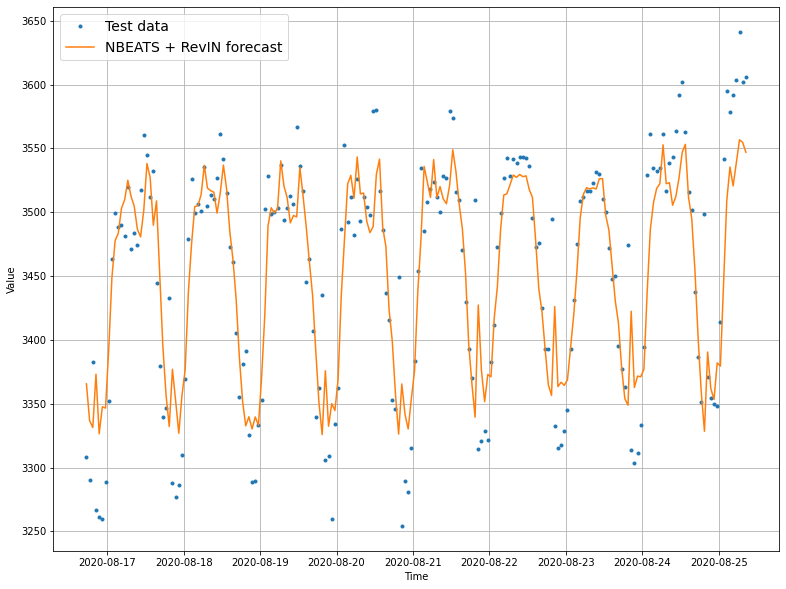

In [22]:
plt.figure(figsize=(13, 10))
offset = 0 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_test.index[offset:], values=y_test[offset:], format = ".", start=offset, label="Test data")
plot_time_series(timesteps=X_test.index[offset:], values=ensemble_median[offset:], format="-", start=offset, label="NBEATS + RevIN forecast");

In [ ]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 8 # how far to lookback
# Add windowed columns
df_nbeats = dataset50['5'].copy()
for win_size in range(WINDOW_SIZE):
    df_nbeats[f"value+{win_size+1}"] = df_nbeats["value"].shift(periods=win_size+1)
# Make features and labels
X = df_nbeats.dropna().drop("value", axis=1)
y = df_nbeats.dropna()["value"]

# Make train and test sets
split_size = int(len(X) * 0.75)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
print(len(X_train), len(y_train), len(X_test), len(y_test))

# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset


In [31]:
# Get list of trained ensemble models
model_5 = get_ensemble_models(key = '5', num_iter=5, num_epochs=1000)


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 2725.79it/s]


Optimizing model by reducing: mae for 1000 epochs, model number: 0, window size: 7

Epoch 134: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 234: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.



 33%|███▎      | 1/3 [00:18<00:36, 18.18s/it]

100%|██████████| 8/8 [00:00<00:00, 2854.97it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 210: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 310: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.



 67%|██████▋   | 2/3 [00:39<00:19, 19.84s/it]

100%|██████████| 8/8 [00:00<00:00, 2547.99it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 190: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 290: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 2647.08it/s]

Optimizing model by reducing: mae for 1000 epochs, model number: 1, window size: 7



Epoch 175: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 275: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.



 33%|███▎      | 1/3 [00:18<00:37, 18.79s/it]

100%|██████████| 8/8 [00:00<00:00, 2527.26it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 169: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 269: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.



 67%|██████▋   | 2/3 [00:37<00:18, 18.57s/it]

100%|██████████| 8/8 [00:00<00:00, 2174.20it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 339: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 763: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 863: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 963: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 1063: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 1163: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.

Epoch 1263: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-10.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 2577.34it/s]


Optimizing model by reducing: mae for 1000 epochs, model number: 2, window size: 7

Epoch 309: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 571: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 671: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



 33%|███▎      | 1/3 [00:39<01:19, 39.56s/it]

100%|██████████| 8/8 [00:00<00:00, 2508.93it/s]


Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7

Epoch 131: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 231: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.



 67%|██████▋   | 2/3 [00:56<00:26, 26.42s/it]

100%|██████████| 8/8 [00:00<00:00, 2516.65it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 127: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 227: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 2691.46it/s]

Optimizing model by reducing: mae for 1000 epochs, model number: 3, window size: 7



Epoch 136: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 236: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.



 33%|███▎      | 1/3 [00:17<00:35, 17.51s/it]

100%|██████████| 8/8 [00:00<00:00, 2638.34it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 259: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 936: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1036: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



 67%|██████▋   | 2/3 [01:18<00:43, 43.25s/it]

100%|██████████| 8/8 [00:00<00:00, 2449.23it/s]


Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7

Epoch 141: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 537: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 637: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 2710.37it/s]

Optimizing model by reducing: mae for 1000 epochs, model number: 4, window size: 7



Epoch 186: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 286: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.



 33%|███▎      | 1/3 [00:19<00:38, 19.05s/it]

100%|██████████| 8/8 [00:00<00:00, 2724.24it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 144: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 244: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.



 67%|██████▋   | 2/3 [00:37<00:18, 18.40s/it]

100%|██████████| 8/8 [00:00<00:00, 1842.33it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 439: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 539: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.



100%|██████████| 5/5 [07:11<00:00, 86.33s/it]


In [33]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=model_5,
                                     data=test_dataset)
ensemble_preds

1/1 [==============================] - 1s 828ms/step


<tf.Tensor: shape=(15, 203), dtype=float32, numpy=
array([[4.1518745, 4.16041  , 4.1655755, ..., 4.2298145, 4.217919 ,
        4.207972 ],
       [4.151097 , 4.151882 , 4.1555834, ..., 4.1817946, 4.189128 ,
        4.195547 ],
       [4.1338463, 4.1301146, 4.128428 , ..., 4.183097 , 4.196316 ,
        4.2052054],
       ...,
       [4.1403737, 4.137625 , 4.135718 , ..., 4.168714 , 4.17676  ,
        4.1979036],
       [4.156951 , 4.1540976, 4.1609683, ..., 4.1598225, 4.16648  ,
        4.1779447],
       [4.1436753, 4.1496053, 4.150184 , ..., 4.181423 , 4.184593 ,
        4.189276 ]], dtype=float32)>

In [34]:
import numpy as np
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results


{'mae': 0.037641846,
 'mse': 0.001879538,
 'rmse': 0.043353636,
 'mape': 0.8998065,
 'mase': 2.2969658}

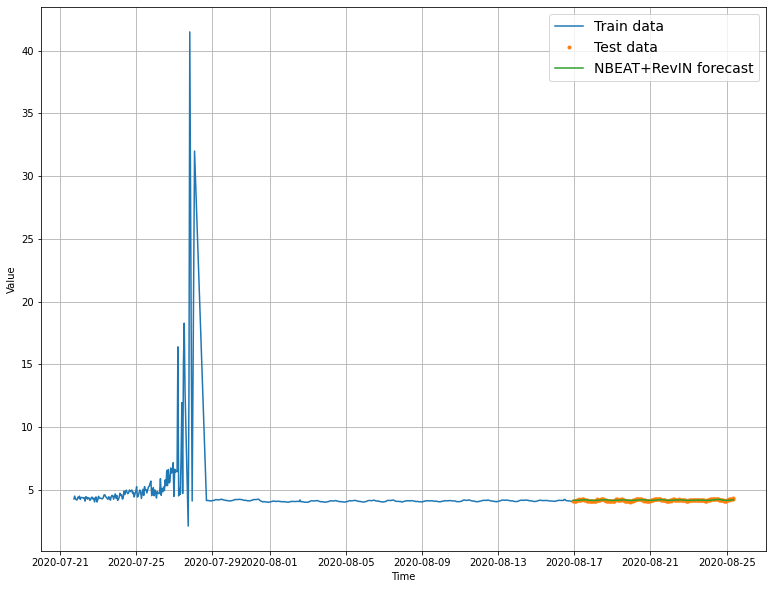

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
ensemble_median = np.median(ensemble_preds, axis=0)
offset = 0 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_train.index[offset:], values=y_train[offset:], label="Train data")
plot_time_series(timesteps=X_test.index[offset:], values=y_test[offset:], format = '.', start=offset, label="Test data")
plot_time_series(timesteps=X_test.index[offset:], values=ensemble_median[offset:], start=offset, label="NBEAT+RevIN forecast");

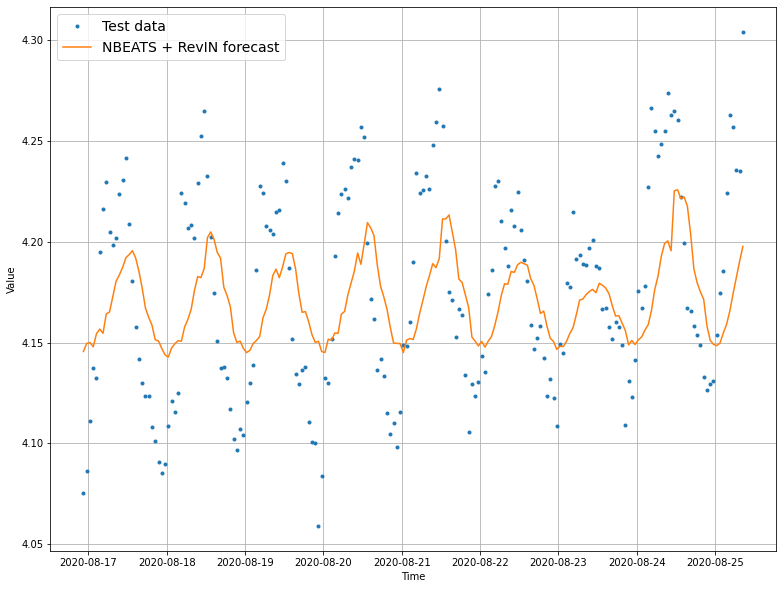

In [46]:
plt.figure(figsize=(13, 10))
offset = 0
plot_time_series(timesteps=X_test.index[offset:], values=y_test[offset:], format = ".", start=offset, label="Test data")
plot_time_series(timesteps=X_test.index[offset:], values=ensemble_median[offset:], format="-", start=offset, label="NBEATS + RevIN forecast");

In [23]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 8 # how far to lookback
# Add windowed columns
df_nbeats = dataset50['7'].copy()
for win_size in range(WINDOW_SIZE):
    df_nbeats[f"value+{win_size+1}"] = df_nbeats["value"].shift(periods=win_size+1)
# Make features and labels
X = df_nbeats.dropna().drop("value", axis=1)
y = df_nbeats.dropna()["value"]

# Make train and test sets
split_size = int(len(X) * 0.75)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
print(len(X_train), len(y_train), len(X_test), len(y_test))

# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

624 624 208 208


(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [25]:
# Get list of trained ensemble models
model_7 = get_ensemble_models(key = '7', num_iter=5, num_epochs=1000)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 2646.04it/s]


Optimizing model by reducing: mae for 1000 epochs, model number: 0, window size: 7

Epoch 160: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 439: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1588: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1753: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 1853: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



 33%|███▎      | 1/3 [01:25<02:50, 85.20s/it]

100%|██████████| 8/8 [00:00<00:00, 2652.73it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 181: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 964: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1083: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1183: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 67%|██████▋   | 2/3 [02:28<01:12, 72.48s/it]

100%|██████████| 8/8 [00:00<00:00, 2582.70it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 208: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 888: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 988: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 2624.52it/s]

Optimizing model by reducing: mae for 1000 epochs, model number: 1, window size: 7



Epoch 426: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 1028: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1128: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



 33%|███▎      | 1/3 [00:56<01:53, 56.62s/it]

100%|██████████| 8/8 [00:00<00:00, 2379.92it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 119: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 325: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1179: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1441: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 1541: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



 67%|██████▋   | 2/3 [02:11<01:07, 67.12s/it]

100%|██████████| 8/8 [00:00<00:00, 2501.45it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 410: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 1142: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1242: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 2461.63it/s]

Optimizing model by reducing: mae for 1000 epochs, model number: 2, window size: 7



Epoch 172: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 523: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 818: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 932: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 1032: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



 33%|███▎      | 1/3 [00:53<01:47, 53.64s/it]

100%|██████████| 8/8 [00:00<00:00, 2792.25it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 252: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 725: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 861: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 961: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 67%|██████▋   | 2/3 [01:43<00:51, 51.48s/it]

100%|██████████| 8/8 [00:00<00:00, 2661.15it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 255: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 743: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 843: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 2750.59it/s]

Optimizing model by reducing: mae for 1000 epochs, model number: 3, window size: 7



Epoch 479: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 913: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1013: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



 33%|███▎      | 1/3 [00:49<01:39, 49.92s/it]

100%|██████████| 8/8 [00:00<00:00, 2704.69it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 228: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 882: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 999: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1099: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 67%|██████▋   | 2/3 [01:47<00:54, 54.22s/it]

100%|██████████| 8/8 [00:00<00:00, 2290.25it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 741: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 841: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 2652.94it/s]

Optimizing model by reducing: mae for 1000 epochs, model number: 4, window size: 7



Epoch 208: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 725: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 890: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1021: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 1206: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 1306: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.



 33%|███▎      | 1/3 [01:03<02:07, 63.80s/it]

100%|██████████| 8/8 [00:00<00:00, 2573.78it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 204: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 883: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 983: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



 67%|██████▋   | 2/3 [01:54<00:55, 56.00s/it]

100%|██████████| 8/8 [00:00<00:00, 2465.79it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 320: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 1028: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1128: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



100%|██████████| 5/5 [14:25<00:00, 173.17s/it]


In [26]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=model_7,
                                     data=test_dataset)
ensemble_preds

1/1 [==============================] - 1s 756ms/step


<tf.Tensor: shape=(15, 208), dtype=float32, numpy=
array([[1716.5548, 1639.7793, 1403.8049, ..., 2639.689 , 2243.7324,
        2383.3403],
       [1431.508 , 1383.2533, 1800.4843, ..., 1821.9728, 2596.145 ,
        2456.1262],
       [1446.4297, 1562.9995, 1399.6868, ..., 1612.667 , 2078.6548,
        1395.2753],
       ...,
       [1327.433 , 1745.3784, 1448.0779, ..., 2017.3292, 2244.395 ,
        1355.1304],
       [1714.6685, 1428.0078, 1732.1509, ..., 1477.1862, 2200.1143,
        1907.4901],
       [1438.4232, 1611.1312, 1452.3005, ..., 1617.327 , 2322.288 ,
        1221.73  ]], dtype=float32)>

In [27]:
import numpy as np
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

{'mae': 174.61816,
 'mse': 59687.13,
 'rmse': 244.3095,
 'mape': 12.349029,
 'mase': 1.0740503}

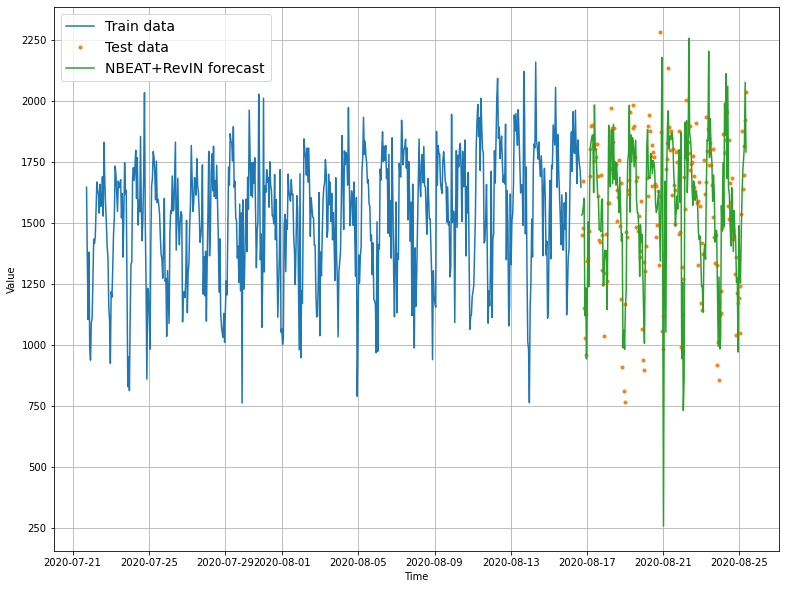

In [28]:

import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
ensemble_median = np.median(ensemble_preds, axis=0)
offset = 0 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_train.index[offset:], values=y_train[offset:], label="Train data")
plot_time_series(timesteps=X_test.index[offset:], values=y_test[offset:], format = '.', start=offset, label="Test data")
plot_time_series(timesteps=X_test.index[offset:], values=ensemble_median[offset:], start=offset, label="NBEAT+RevIN forecast");

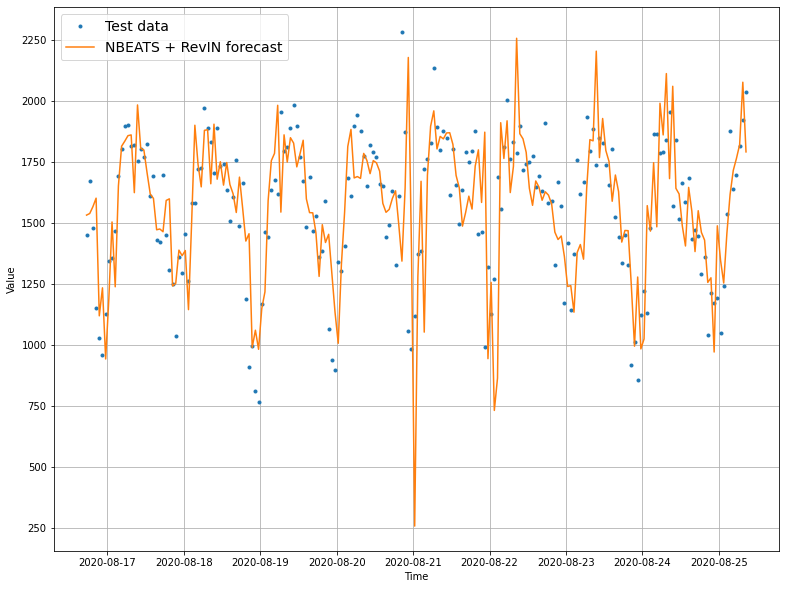

In [29]:
plt.figure(figsize=(13, 10))
offset = 0 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_test.index[offset:], values=y_test[offset:], format = ".", start=offset, label="Test data")
plot_time_series(timesteps=X_test.index[offset:], values=ensemble_median[offset:], format="-", start=offset, label="NBEATS + RevIN forecast");

In [14]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 8 # how far to lookback
# Add windowed columns
df_nbeats = dataset50['8'].copy()
for win_size in range(WINDOW_SIZE):
    df_nbeats[f"value+{win_size+1}"] = df_nbeats["value"].shift(periods=win_size+1)
# Make features and labels
X = df_nbeats.dropna().drop("value", axis=1)
y = df_nbeats.dropna()["value"]

# Make train and test sets
split_size = int(len(X) * 0.75)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
print(len(X_train), len(y_train), len(X_test), len(y_test))

# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

624 624 208 208


(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [15]:
# Get list of trained ensemble models
model_8 = get_ensemble_models(key = '8', num_iter=5, num_epochs=1000)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 1721.53it/s]


Optimizing model by reducing: mae for 1000 epochs, model number: 0, window size: 7

Epoch 662: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 965: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1074: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1174: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 33%|███▎      | 1/3 [01:26<02:53, 86.68s/it]

100%|██████████| 8/8 [00:00<00:00, 1889.86it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 441: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 873: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 990: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1090: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 67%|██████▋   | 2/3 [02:52<01:26, 86.38s/it]

100%|██████████| 8/8 [00:00<00:00, 1784.53it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 489: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 825: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1852: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1952: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 1795.41it/s]

Optimizing model by reducing: mae for 1000 epochs, model number: 1, window size: 7



Epoch 361: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 776: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 908: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1008: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 33%|███▎      | 1/3 [01:18<02:36, 78.14s/it]

100%|██████████| 8/8 [00:00<00:00, 1489.85it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 737: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 1029: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1132: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1232: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 67%|██████▋   | 2/3 [02:49<01:25, 85.85s/it]

100%|██████████| 8/8 [00:00<00:00, 1790.33it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 166: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 586: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1531: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1671: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 1771: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 1392.13it/s]

Optimizing model by reducing: mae for 1000 epochs, model number: 2, window size: 7



Epoch 664: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 1109: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1325: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1425: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 33%|███▎      | 1/3 [01:41<03:23, 101.82s/it]

100%|██████████| 8/8 [00:00<00:00, 1845.78it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 204: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 503: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 630: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 730: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 67%|██████▋   | 2/3 [02:42<01:17, 77.57s/it] 

100%|██████████| 8/8 [00:00<00:00, 1809.45it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 372: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 620: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1222: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1322: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 1773.30it/s]

Optimizing model by reducing: mae for 1000 epochs, model number: 3, window size: 7



Epoch 181: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 483: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1196: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 2468: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 2568: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



 33%|███▎      | 1/3 [02:59<05:59, 179.98s/it]

100%|██████████| 8/8 [00:00<00:00, 1925.65it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 260: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 612: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1245: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 2761: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 2861: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



 67%|██████▋   | 2/3 [06:17<03:10, 190.56s/it]

100%|██████████| 8/8 [00:00<00:00, 1979.38it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 494: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 808: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1298: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1398: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 1871.10it/s]

Optimizing model by reducing: mae for 1000 epochs, model number: 4, window size: 7



Epoch 277: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 799: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1374: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1474: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 33%|███▎      | 1/3 [01:55<03:50, 115.43s/it]

100%|██████████| 8/8 [00:00<00:00, 1936.20it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 451: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 964: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1826: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1926: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 67%|██████▋   | 2/3 [04:10<02:06, 126.96s/it]

100%|██████████| 8/8 [00:00<00:00, 1831.17it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 671: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 917: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1388: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1488: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



100%|██████████| 5/5 [28:28<00:00, 341.79s/it]


In [16]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=model_8,
                                     data=test_dataset)
ensemble_preds

1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(15, 208), dtype=float32, numpy=
array([[-76720.836 , -15962.135 ,  -5876.125 , ...,   7428.232 ,
         -3504.331 ,   9589.965 ],
       [ 95806.484 ,  -5702.843 , -17668.229 , ...,  33097.77  ,
         10916.759 ,  24120.64  ],
       [ 61822.023 , -10177.059 ,  40018.97  , ...,  17836.234 ,
         21234.014 ,  36087.17  ],
       ...,
       [ -8150.3574, -10139.115 , -13733.916 , ...,  25444.148 ,
         61257.79  ,   2682.7031],
       [-29282.65  ,  13000.8125,  34886.258 , ...,   5600.857 ,
         63723.83  ,   1330.8418],
       [-91846.695 , -24373.217 , -19388.346 , ...,  20835.535 ,
         16838.195 ,  58121.844 ]], dtype=float32)>

In [17]:
import numpy as np
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

{'mae': 7349.5547,
 'mse': 105993096.0,
 'rmse': 10295.295,
 'mape': 283.79337,
 'mase': 3.9054837}

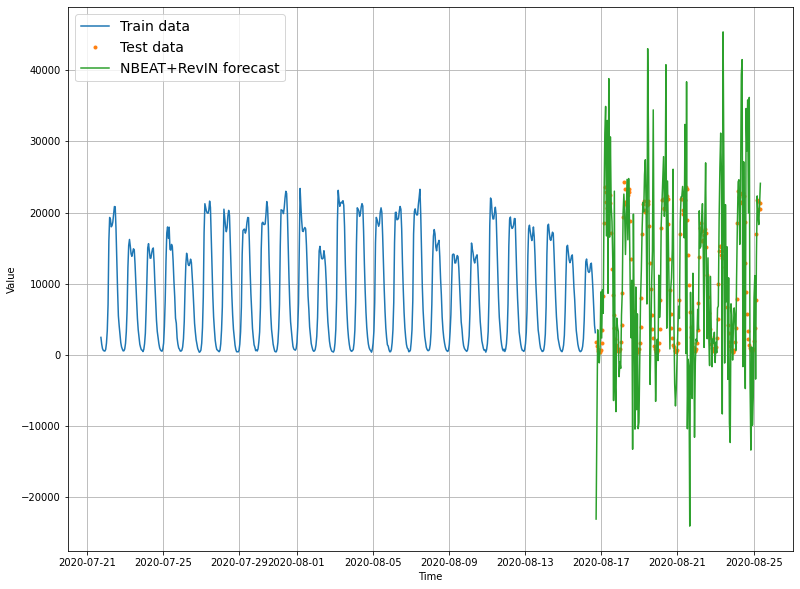

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
ensemble_median = np.median(ensemble_preds, axis=0)
offset = 0 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_train.index[offset:], values=y_train[offset:], label="Train data")
plot_time_series(timesteps=X_test.index[offset:], values=y_test[offset:], format = '.', start=offset, label="Test data")
plot_time_series(timesteps=X_test.index[offset:], values=ensemble_median[offset:], start=offset, label="NBEAT+RevIN forecast");


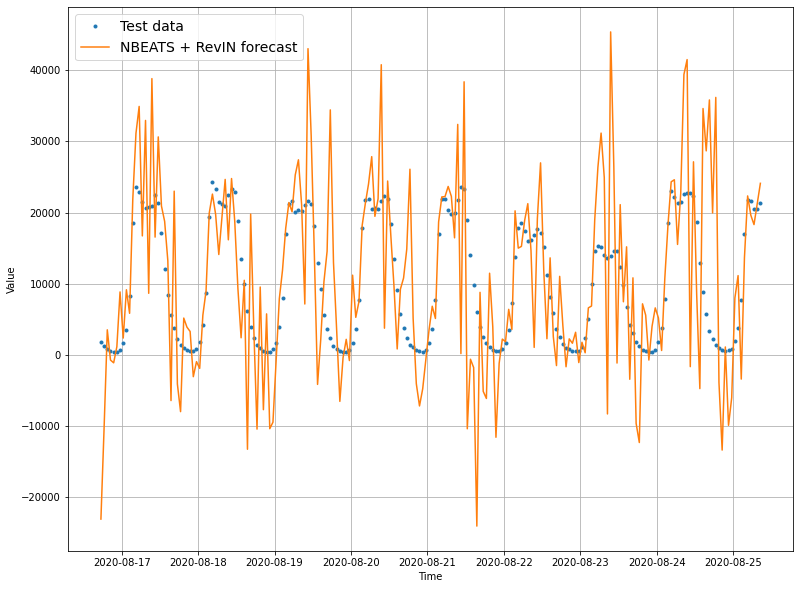

In [19]:
plt.figure(figsize=(13, 10))
offset = 0 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_test.index[offset:], values=y_test[offset:], format = ".", start=offset, label="Test data")
plot_time_series(timesteps=X_test.index[offset:], values=ensemble_median[offset:], format="-", start=offset, label="NBEATS + RevIN forecast");

In [14]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 8 # how far to lookback
# Add windowed columns
df_nbeats = dataset50['9'].copy()
for win_size in range(WINDOW_SIZE):
    df_nbeats[f"value+{win_size+1}"] = df_nbeats["value"].shift(periods=win_size+1)
# Make features and labels
X = df_nbeats.dropna().drop("value", axis=1)
y = df_nbeats.dropna()["value"]

# Make train and test sets
split_size = int(len(X) * 0.75)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
print(len(X_train), len(y_train), len(X_test), len(y_test))

# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

624 624 208 208


(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [15]:

# Get list of trained ensemble models
model_9 = get_ensemble_models(key = '9', num_iter=5, num_epochs=1000)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 2023.55it/s]


Optimizing model by reducing: mae for 1000 epochs, model number: 0, window size: 7

Epoch 251: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 683: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 2021: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 2121: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 33%|███▎      | 1/3 [02:12<04:24, 132.13s/it]

100%|██████████| 8/8 [00:00<00:00, 2011.29it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 666: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 968: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1102: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1202: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 67%|██████▋   | 2/3 [03:28<01:39, 99.32s/it] 

100%|██████████| 8/8 [00:00<00:00, 1710.48it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 267: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 589: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 978: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1078: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 2082.06it/s]

Optimizing model by reducing: mae for 1000 epochs, model number: 1, window size: 7



Epoch 164: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 405: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 549: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 649: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 33%|███▎      | 1/3 [00:50<01:41, 50.55s/it]

100%|██████████| 8/8 [00:00<00:00, 1502.86it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 462: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 785: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1609: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1709: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 67%|██████▋   | 2/3 [02:42<01:26, 86.65s/it]

100%|██████████| 8/8 [00:00<00:00, 1964.89it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 345: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 570: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1842: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1942: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 1765.09it/s]

Optimizing model by reducing: mae for 1000 epochs, model number: 2, window size: 7



Epoch 233: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 574: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1177: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1277: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 33%|███▎      | 1/3 [01:31<03:03, 91.78s/it]

100%|██████████| 8/8 [00:00<00:00, 1927.31it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 282: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 615: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 752: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 852: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 67%|██████▋   | 2/3 [02:31<01:12, 72.70s/it]

100%|██████████| 8/8 [00:00<00:00, 1961.10it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 410: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 924: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1059: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1159: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 2038.79it/s]

Optimizing model by reducing: mae for 1000 epochs, model number: 3, window size: 7



Epoch 349: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 749: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 861: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 961: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 33%|███▎      | 1/3 [01:08<02:16, 68.29s/it]

100%|██████████| 8/8 [00:00<00:00, 2064.13it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 473: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 778: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 903: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1003: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 67%|██████▋   | 2/3 [02:16<01:08, 68.15s/it]

100%|██████████| 8/8 [00:00<00:00, 2004.21it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 203: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 644: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 773: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 873: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 1892.63it/s]

Optimizing model by reducing: mae for 1000 epochs, model number: 4, window size: 7



Epoch 329: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 601: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1521: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1632: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 1732: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



 33%|███▎      | 1/3 [01:47<03:35, 107.67s/it]

100%|██████████| 8/8 [00:00<00:00, 1913.90it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 185: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 576: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1632: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1741: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 1841: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



 67%|██████▋   | 2/3 [03:50<01:56, 116.65s/it]

100%|██████████| 8/8 [00:00<00:00, 1901.96it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 1361: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 1495: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1595: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



100%|██████████| 5/5 [22:09<00:00, 265.90s/it]


In [16]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=model_9,
                                     data=test_dataset)
ensemble_preds

1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(15, 208), dtype=float32, numpy=
array([[ 301229.38 ,  -24508.816, -259204.66 , ...,   17739.33 ,
          38416.867,   21947.93 ],
       [ -85096.3  ,  -66305.03 ,  -46527.715, ...,   79190.69 ,
          95107.56 ,  -19565.355],
       [ 152617.25 ,  203267.2  , -167432.39 , ...,  -39983.1  ,
         146793.86 ,  -73467.86 ],
       ...,
       [ 156410.73 , -235716.7  ,  -27985.246, ...,  -72161.08 ,
          54341.797,   39882.758],
       [-302681.53 ,  553632.8  , -168819.05 , ...,  -40309.832,
          94858.78 , -105244.234],
       [  56384.28 ,   95527.16 ,  -92479.45 , ...,   12620.991,
          80469.53 ,   58042.445]], dtype=float32)>

In [17]:
import numpy as np
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

{'mae': 28701.592,
 'mse': 1581590400.0,
 'rmse': 39769.215,
 'mape': 626.6846,
 'mase': 7.924992}

<Figure size 936x720 with 0 Axes>

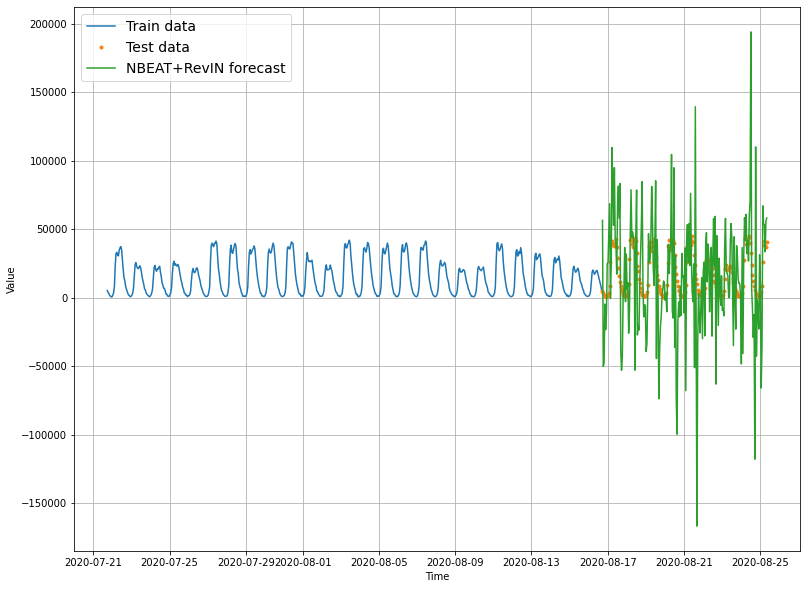

<Figure size 936x720 with 0 Axes>

In [18]:

import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
ensemble_median = np.median(ensemble_preds, axis=0)
offset = 0 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_train.index[offset:], values=y_train[offset:], label="Train data")
plot_time_series(timesteps=X_test.index[offset:], values=y_test[offset:], format = '.', start=offset, label="Test data")
plot_time_series(timesteps=X_test.index[offset:], values=ensemble_median[offset:], start=offset, label="NBEAT+RevIN forecast");


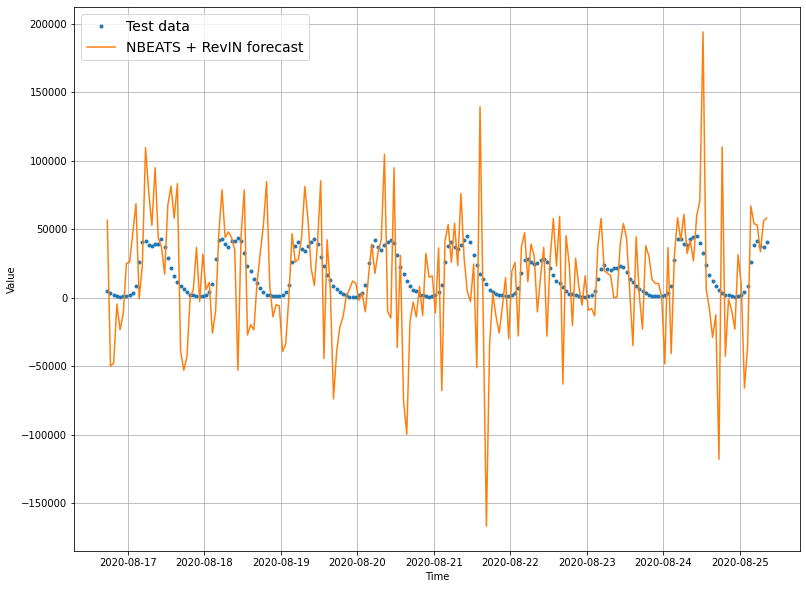

In [19]:
plt.figure(figsize=(13, 10))
offset = 0 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_test.index[offset:], values=y_test[offset:], format = ".", start=offset, label="Test data")
plot_time_series(timesteps=X_test.index[offset:], values=ensemble_median[offset:], format="-", start=offset, label="NBEATS + RevIN forecast");

In [14]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 8 # how far to lookback
# Add windowed columns
df_nbeats = dataset50['10'].copy()
for win_size in range(WINDOW_SIZE):
    df_nbeats[f"value+{win_size+1}"] = df_nbeats["value"].shift(periods=win_size+1)
# Make features and labels
X = df_nbeats.dropna().drop("value", axis=1)
y = df_nbeats.dropna()["value"]

# Make train and test sets
split_size = int(len(X) * 0.75)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
print(len(X_train), len(y_train), len(X_test), len(y_test))

# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset


624 624 208 208


(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [15]:
# Get list of trained ensemble models
model_10 = get_ensemble_models(key = '10', num_iter=5, num_epochs=1000)


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 2012.74it/s]


Optimizing model by reducing: mae for 1000 epochs, model number: 0, window size: 7

Epoch 319: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 419: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.



 33%|███▎      | 1/3 [00:34<01:09, 34.53s/it]

100%|██████████| 8/8 [00:00<00:00, 1917.40it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 312: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 412: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.



 67%|██████▋   | 2/3 [01:06<00:33, 33.04s/it]

100%|██████████| 8/8 [00:00<00:00, 1876.75it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 338: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 438: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 1871.20it/s]

Optimizing model by reducing: mae for 1000 epochs, model number: 1, window size: 7



Epoch 183: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 283: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.



 33%|███▎      | 1/3 [00:26<00:52, 26.49s/it]

100%|██████████| 8/8 [00:00<00:00, 2116.87it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 231: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 331: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.



 67%|██████▋   | 2/3 [00:55<00:28, 28.03s/it]

100%|██████████| 8/8 [00:00<00:00, 1764.26it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 279: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 379: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 1909.54it/s]

Optimizing model by reducing: mae for 1000 epochs, model number: 2, window size: 7



Epoch 241: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 341: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.



 33%|███▎      | 1/3 [00:29<00:58, 29.30s/it]

100%|██████████| 8/8 [00:00<00:00, 1979.26it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 258: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 358: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.



 67%|██████▋   | 2/3 [00:58<00:29, 29.23s/it]

100%|██████████| 8/8 [00:00<00:00, 1947.89it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 353: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 453: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 1899.06it/s]

Optimizing model by reducing: mae for 1000 epochs, model number: 3, window size: 7



Epoch 346: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 446: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.



 33%|███▎      | 1/3 [00:34<01:09, 34.73s/it]

100%|██████████| 8/8 [00:00<00:00, 1961.22it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 277: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 377: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.



 67%|██████▋   | 2/3 [01:06<00:33, 33.04s/it]

100%|██████████| 8/8 [00:00<00:00, 2109.94it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 202: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 302: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 1634.89it/s]

Optimizing model by reducing: mae for 1000 epochs, model number: 4, window size: 7



Epoch 275: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 375: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 475: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



 33%|███▎      | 1/3 [00:36<01:13, 36.65s/it]

100%|██████████| 8/8 [00:00<00:00, 1626.09it/s]


Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7

Epoch 249: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 349: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.



 67%|██████▋   | 2/3 [01:06<00:32, 32.84s/it]

100%|██████████| 8/8 [00:00<00:00, 2030.28it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 357: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 457: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.



100%|██████████| 5/5 [07:56<00:00, 95.23s/it]


In [16]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=model_10,
                                     data=test_dataset)
ensemble_preds

1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(15, 208), dtype=float32, numpy=
array([[6.973109 , 6.9408393, 6.868649 , ..., 7.036752 , 7.044182 ,
        7.024728 ],
       [6.9663734, 6.949175 , 6.8881235, ..., 7.0217786, 7.0332303,
        7.010715 ],
       [6.953696 , 6.9268403, 6.875089 , ..., 7.036485 , 7.038026 ,
        7.013994 ],
       ...,
       [6.979501 , 6.9356184, 6.8672028, ..., 7.0295453, 7.03866  ,
        7.026586 ],
       [6.967725 , 6.941021 , 6.8878865, ..., 7.030783 , 7.040863 ,
        7.0149765],
       [6.9588747, 6.928234 , 6.869248 , ..., 7.028833 , 7.0457106,
        7.024534 ]], dtype=float32)>

In [17]:
import numpy as np
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results


{'mae': 0.06465431,
 'mse': 0.011713349,
 'rmse': 0.10822823,
 'mape': 0.94714284,
 'mase': 0.87623537}

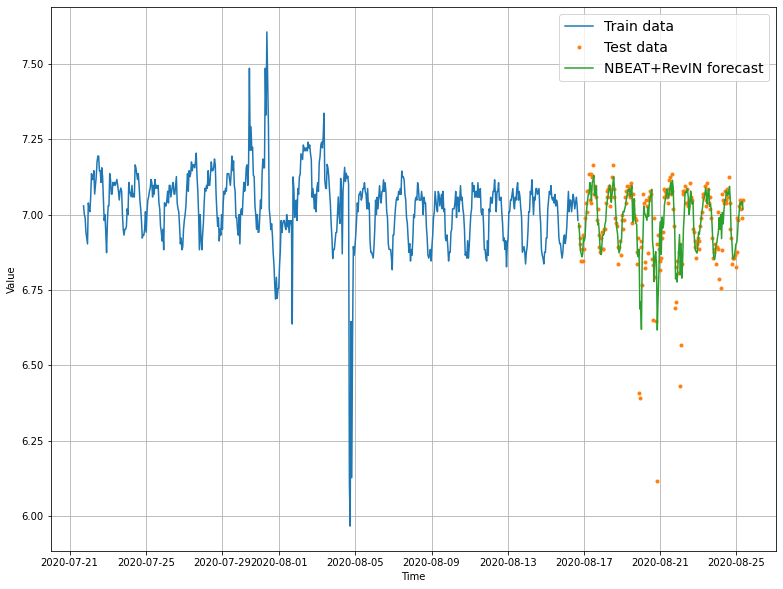

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
ensemble_median = np.median(ensemble_preds, axis=0)
offset = 0 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_train.index[offset:], values=y_train[offset:], label="Train data")
plot_time_series(timesteps=X_test.index[offset:], values=y_test[offset:], format = '.', start=offset, label="Test data")
plot_time_series(timesteps=X_test.index[offset:], values=ensemble_median[offset:], start=offset, label="NBEAT+RevIN forecast");

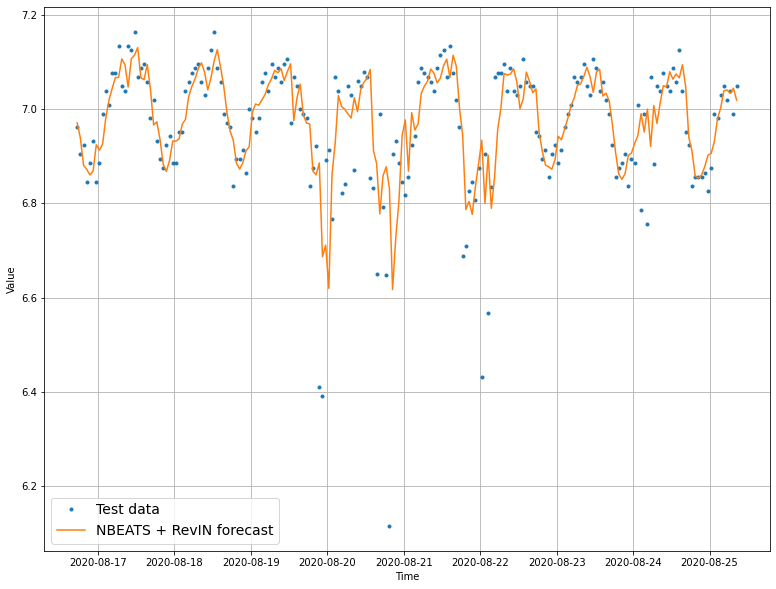

In [19]:

plt.figure(figsize=(13, 10))
offset = 0 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_test.index[offset:], values=y_test[offset:], format = ".", start=offset, label="Test data")
plot_time_series(timesteps=X_test.index[offset:], values=ensemble_median[offset:], format="-", start=offset, label="NBEATS + RevIN forecast");

In [14]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 8 # how far to lookback
# Add windowed columns
df_nbeats = dataset50['11'].copy()
for win_size in range(WINDOW_SIZE):
    df_nbeats[f"value+{win_size+1}"] = df_nbeats["value"].shift(periods=win_size+1)
# Make features and labels
X = df_nbeats.dropna().drop("value", axis=1)
y = df_nbeats.dropna()["value"]

# Make train and test sets
split_size = int(len(X) * 0.75)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
print(len(X_train), len(y_train), len(X_test), len(y_test))

# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

624 624 208 208


(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [15]:
# Get list of trained ensemble models
model_11 = get_ensemble_models(key = '11', num_iter=5, num_epochs=1000)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 2022.33it/s]


Optimizing model by reducing: mae for 1000 epochs, model number: 0, window size: 7

Epoch 355: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 919: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1033: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1133: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 33%|███▎      | 1/3 [01:21<02:42, 81.15s/it]

100%|██████████| 8/8 [00:00<00:00, 1736.95it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 193: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 971: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1071: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1171: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 67%|██████▋   | 2/3 [02:49<01:25, 85.25s/it]

100%|██████████| 8/8 [00:00<00:00, 1871.41it/s]


Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7

Epoch 263: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 634: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 734: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 1989.47it/s]


Optimizing model by reducing: mae for 1000 epochs, model number: 1, window size: 7

Epoch 364: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 464: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.



 33%|███▎      | 1/3 [00:35<01:10, 35.14s/it]

100%|██████████| 8/8 [00:00<00:00, 2007.56it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 271: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 405: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 505: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



 67%|██████▋   | 2/3 [01:13<00:37, 37.11s/it]

100%|██████████| 8/8 [00:00<00:00, 1906.18it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 173: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 777: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 877: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 1884.02it/s]


Optimizing model by reducing: mae for 1000 epochs, model number: 2, window size: 7

Epoch 263: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 621: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 721: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



 33%|███▎      | 1/3 [00:56<01:53, 56.96s/it]

100%|██████████| 8/8 [00:00<00:00, 2052.89it/s]


Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7

Epoch 298: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 692: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 792: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



 67%|██████▋   | 2/3 [02:06<01:04, 64.08s/it]

100%|██████████| 8/8 [00:00<00:00, 1931.41it/s]


Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7

Epoch 583: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 683: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 1883.28it/s]

Optimizing model by reducing: mae for 1000 epochs, model number: 3, window size: 7



Epoch 322: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 422: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.



 33%|███▎      | 1/3 [00:33<01:06, 33.24s/it]

100%|██████████| 8/8 [00:00<00:00, 1880.54it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 154: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 511: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 611: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



 67%|██████▋   | 2/3 [01:29<00:46, 46.59s/it]

100%|██████████| 8/8 [00:00<00:00, 1951.41it/s]


Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7

Epoch 462: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 562: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 1735.69it/s]

Optimizing model by reducing: mae for 1000 epochs, model number: 4, window size: 7



Epoch 165: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 334: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 434: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



 33%|███▎      | 1/3 [00:37<01:14, 37.05s/it]

100%|██████████| 8/8 [00:00<00:00, 1939.23it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 309: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 653: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 753: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



 67%|██████▋   | 2/3 [01:37<00:50, 50.77s/it]

100%|██████████| 8/8 [00:00<00:00, 1900.13it/s]


Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7

Epoch 463: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 569: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 669: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



100%|██████████| 5/5 [13:40<00:00, 164.06s/it]


In [16]:

# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=model_11,
                                     data=test_dataset)
ensemble_preds


1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(15, 208), dtype=float32, numpy=
array([[8.952076 , 8.904839 , 8.869607 , ..., 9.140829 , 9.121127 ,
        9.160029 ],
       [8.952759 , 8.924861 , 8.875573 , ..., 9.148081 , 9.1219225,
        9.157812 ],
       [8.945501 , 8.9180565, 8.8755   , ..., 9.140527 , 9.12738  ,
        9.153745 ],
       ...,
       [8.933468 , 8.91024  , 8.874398 , ..., 9.137425 , 9.142522 ,
        9.143443 ],
       [8.950188 , 8.916684 , 8.872284 , ..., 9.140334 , 9.121398 ,
        9.158254 ],
       [8.9498005, 8.918046 , 8.875956 , ..., 9.14293  , 9.13473  ,
        9.157136 ]], dtype=float32)>

In [17]:
import numpy as np
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results


{'mae': 0.02240309,
 'mse': 0.0009771561,
 'rmse': 0.031259496,
 'mape': 0.24956898,
 'mase': 0.6824473}

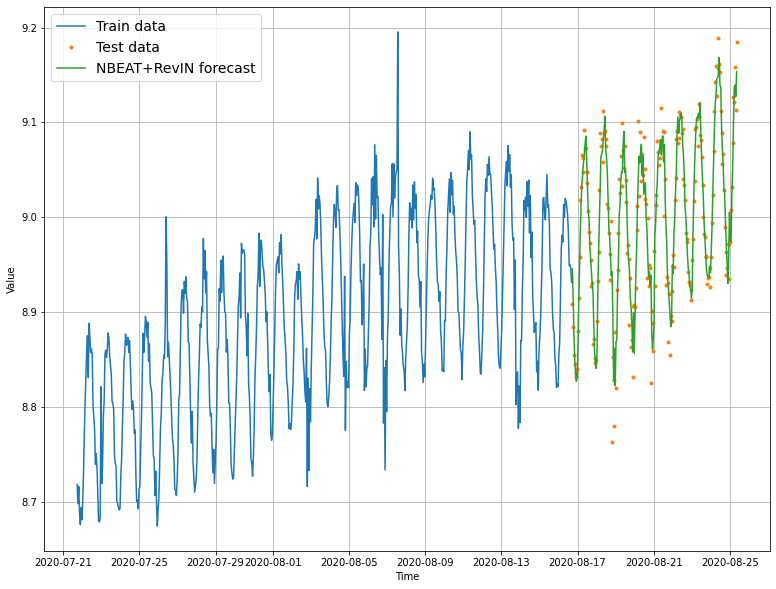

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
ensemble_median = np.median(ensemble_preds, axis=0)
offset = 0 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_train.index[offset:], values=y_train[offset:], label="Train data")
plot_time_series(timesteps=X_test.index[offset:], values=y_test[offset:], format = '.', start=offset, label="Test data")
plot_time_series(timesteps=X_test.index[offset:], values=ensemble_median[offset:], start=offset, label="NBEAT+RevIN forecast");

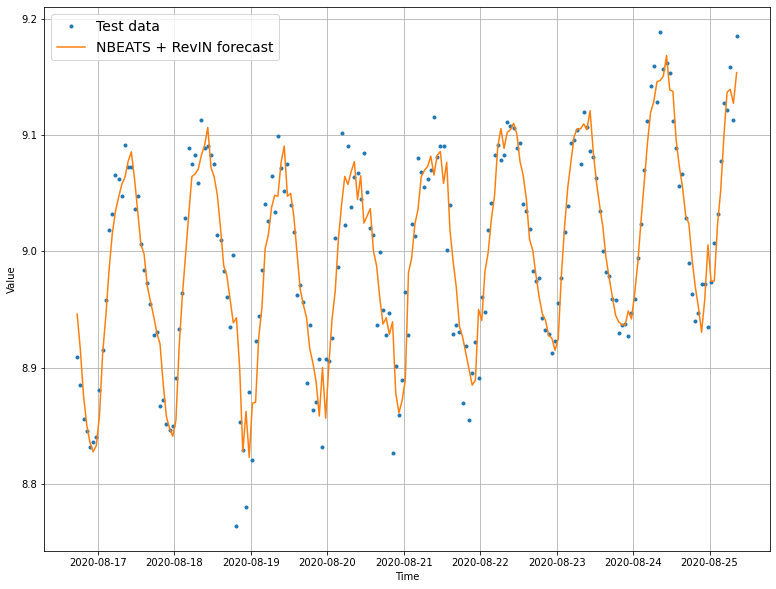

In [19]:
plt.figure(figsize=(13, 10))
offset = 0 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_test.index[offset:], values=y_test[offset:], format = ".", start=offset, label="Test data")
plot_time_series(timesteps=X_test.index[offset:], values=ensemble_median[offset:], format="-", start=offset, label="NBEATS + RevIN forecast");

In [21]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 8 # how far to lookback
# Add windowed columns
df_nbeats = dataset50['12'].copy()
for win_size in range(WINDOW_SIZE):
    df_nbeats[f"value+{win_size+1}"] = df_nbeats["value"].shift(periods=win_size+1)
# Make features and labels
X = df_nbeats.dropna().drop("value", axis=1)
y = df_nbeats.dropna()["value"]

# Make train and test sets
split_size = int(len(X) * 0.75)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
print(len(X_train), len(y_train), len(X_test), len(y_test))

# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

618 618 207 207


(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [15]:

# Get list of trained ensemble models
model_12 = get_ensemble_models(key = '12', num_iter=5, num_epochs=1000)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 2008.41it/s]


Optimizing model by reducing: mae for 1000 epochs, model number: 0, window size: 7

Epoch 443: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 997: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1118: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1218: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 33%|███▎      | 1/3 [01:24<02:49, 84.71s/it]

100%|██████████| 8/8 [00:00<00:00, 1964.78it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 255: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 721: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 846: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 946: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 67%|██████▋   | 2/3 [02:35<01:16, 76.39s/it]

100%|██████████| 8/8 [00:00<00:00, 1774.62it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 150: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 506: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1860: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 2001: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 2101: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 1760.37it/s]

Optimizing model by reducing: mae for 1000 epochs, model number: 1, window size: 7



Epoch 179: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 534: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 2165: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 2265: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 33%|███▎      | 1/3 [02:32<05:04, 152.49s/it]

100%|██████████| 8/8 [00:00<00:00, 2003.73it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 287: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 713: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 843: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 943: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 67%|██████▋   | 2/3 [03:43<01:44, 104.51s/it]

100%|██████████| 8/8 [00:00<00:00, 2039.16it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 696: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 1045: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1179: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1279: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 1945.52it/s]

Optimizing model by reducing: mae for 1000 epochs, model number: 2, window size: 7



Epoch 229: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 637: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1486: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1586: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 33%|███▎      | 1/3 [01:51<03:43, 111.68s/it]

100%|██████████| 8/8 [00:00<00:00, 1920.25it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 670: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 898: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 998: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



 67%|██████▋   | 2/3 [02:58<01:25, 85.45s/it] 

100%|██████████| 8/8 [00:00<00:00, 1964.89it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 174: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 518: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1388: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1506: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 1606: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 2003.97it/s]

Optimizing model by reducing: mae for 1000 epochs, model number: 3, window size: 7



Epoch 185: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 526: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 626: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



 33%|███▎      | 1/3 [00:55<01:50, 55.30s/it]

100%|██████████| 8/8 [00:00<00:00, 1903.91it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 170: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 503: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1952: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 2052: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 67%|██████▋   | 2/3 [03:20<01:48, 108.19s/it]

100%|██████████| 8/8 [00:00<00:00, 1629.49it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 165: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 486: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1632: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1734: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 1834: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 1866.31it/s]

Optimizing model by reducing: mae for 1000 epochs, model number: 4, window size: 7



Epoch 183: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 710: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 810: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



 33%|███▎      | 1/3 [01:03<02:07, 63.56s/it]

100%|██████████| 8/8 [00:00<00:00, 1941.92it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 520: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 1275: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1382: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1482: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 67%|██████▋   | 2/3 [02:43<01:25, 85.18s/it]

100%|██████████| 8/8 [00:00<00:00, 1884.66it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 266: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 769: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 918: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1018: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



100%|██████████| 5/5 [24:26<00:00, 293.37s/it]


In [16]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=model_12,
                                     data=test_dataset)
ensemble_preds


1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(15, 207), dtype=float32, numpy=
array([[ 166555.62  , -146950.23  ,   81836.97  , ...,   83161.42  ,
         -76945.555 , -111018.81  ],
       [  -1997.4785,   20749.578 ,   32410.678 , ...,   29861.438 ,
         -43174.32  ,  -14722.695 ],
       [  73073.95  ,  -74198.234 ,  -46236.71  , ...,   61639.44  ,
         201849.    ,   53196.613 ],
       ...,
       [-122085.11  ,  -15300.348 ,  243939.11  , ...,  111851.68  ,
        -125085.625 ,   22839.793 ],
       [ 153425.78  ,  -94287.266 ,  133749.19  , ...,  173377.28  ,
          56685.96  ,   50886.695 ],
       [  64732.992 , -138171.25  ,  -83496.48  , ...,  -21996.242 ,
         139530.84  ,   83316.25  ]], dtype=float32)>

In [17]:

import numpy as np
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

{'mae': 35313.027,
 'mse': 2374639000.0,
 'rmse': 48730.27,
 'mape': 156.7899,
 'mase': 8.973231}

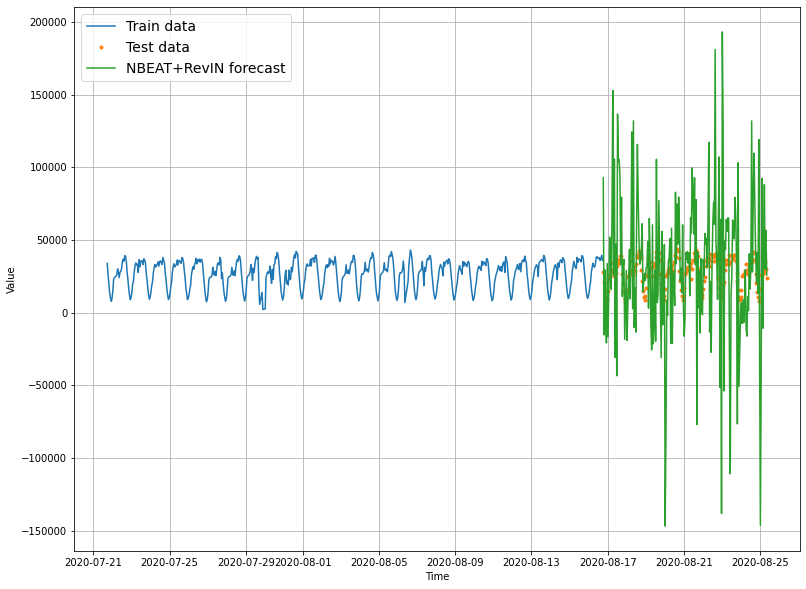

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
ensemble_median = np.median(ensemble_preds, axis=0)
offset = 0 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_train.index[offset:], values=y_train[offset:], label="Train data")
plot_time_series(timesteps=X_test.index[offset:], values=y_test[offset:], format = '.', start=offset, label="Test data")
plot_time_series(timesteps=X_test.index[offset:], values=ensemble_median[offset:], start=offset, label="NBEAT+RevIN forecast");

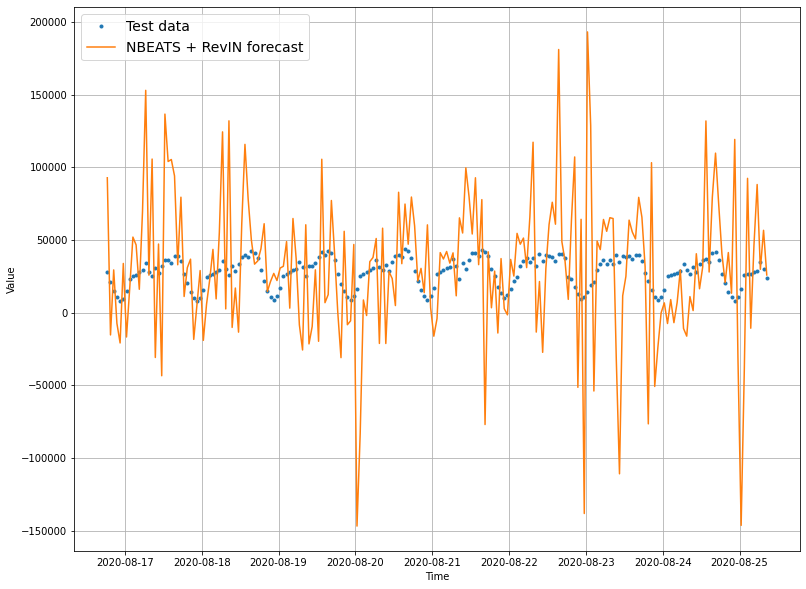

In [19]:
plt.figure(figsize=(13, 10))
offset = 0 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_test.index[offset:], values=y_test[offset:], format = ".", start=offset, label="Test data")
plot_time_series(timesteps=X_test.index[offset:], values=ensemble_median[offset:], format="-", start=offset, label="NBEATS + RevIN forecast");

In [14]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 8 # how far to lookback
# Add windowed columns
df_nbeats = dataset50['14'].copy()
for win_size in range(WINDOW_SIZE):
    df_nbeats[f"value+{win_size+1}"] = df_nbeats["value"].shift(periods=win_size+1)
# Make features and labels
X = df_nbeats.dropna().drop("value", axis=1)
y = df_nbeats.dropna()["value"]

# Make train and test sets
split_size = int(len(X) * 0.75)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
print(len(X_train), len(y_train), len(X_test), len(y_test))

# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

622 622 208 208


(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [15]:

# Get list of trained ensemble models
model_14 = get_ensemble_models(key = '3', num_iter=5, num_epochs=1000)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 1487.74it/s]


Optimizing model by reducing: mae for 1000 epochs, model number: 0, window size: 7

Epoch 209: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 363: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1875: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 2011: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 2111: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



 33%|███▎      | 1/3 [03:16<06:32, 196.15s/it]

100%|██████████| 8/8 [00:00<00:00, 1599.81it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 229: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 422: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 2273: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 2401: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 2501: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



 67%|██████▋   | 2/3 [06:39<03:20, 200.15s/it]

100%|██████████| 8/8 [00:00<00:00, 1564.24it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 193: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 357: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1757: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1875: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 1975: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 1832.77it/s]

Optimizing model by reducing: mae for 1000 epochs, model number: 1, window size: 7



Epoch 211: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 356: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1621: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1750: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 1850: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



 33%|███▎      | 1/3 [02:36<05:13, 156.59s/it]

100%|██████████| 8/8 [00:00<00:00, 1797.91it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 167: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 303: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 964: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



 67%|██████▋   | 2/3 [10:30<05:43, 343.18s/it]

100%|██████████| 8/8 [00:00<00:00, 1882.44it/s]


Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7

Epoch 165: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 333: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 2315: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 2435: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 2535: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 1780.45it/s]

Optimizing model by reducing: mae for 1000 epochs, model number: 2, window size: 7



Epoch 198: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 377: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 2366: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 2478: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 2578: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



 33%|███▎      | 1/3 [03:25<06:51, 205.67s/it]

100%|██████████| 8/8 [00:00<00:00, 1902.72it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 299: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 421: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 2351: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 2452: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 2552: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



 67%|██████▋   | 2/3 [07:15<03:39, 219.71s/it]

100%|██████████| 8/8 [00:00<00:00, 1188.44it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 341: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 473: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 2612: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 2745: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 2845: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 1776.49it/s]

Optimizing model by reducing: mae for 1000 epochs, model number: 3, window size: 7



Epoch 252: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 414: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 2267: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 2390: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 2490: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



 33%|███▎      | 1/3 [03:50<07:41, 230.52s/it]

100%|██████████| 8/8 [00:00<00:00, 1929.52it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 628: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 2186: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 2296: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 2396: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 67%|██████▋   | 2/3 [06:33<03:10, 190.68s/it]

100%|██████████| 8/8 [00:00<00:00, 1776.87it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 174: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 310: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1735: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1854: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 1954: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 1888.79it/s]

Optimizing model by reducing: mae for 1000 epochs, model number: 4, window size: 7



Epoch 175: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 277: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1283: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1410: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 1510: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



 33%|███▎      | 1/3 [02:13<04:27, 133.63s/it]

100%|██████████| 8/8 [00:00<00:00, 930.90it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 331: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 628: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 3220: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 3326: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 3426: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



 67%|██████▋   | 2/3 [07:08<03:48, 228.59s/it]

100%|██████████| 8/8 [00:00<00:00, 1712.57it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 327: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 458: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 3339: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 3439: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



100%|██████████| 5/5 [57:14<00:00, 686.90s/it]


In [20]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=model_14,
                                     data=test_dataset)
ensemble_preds

1/1 [==============================] - 0s 13ms/step


<tf.Tensor: shape=(15, 208), dtype=float32, numpy=
array([[ 99.85717 ,  99.8547  ,  99.86382 , ...,  99.94823 ,  99.7588  ,
         99.546295],
       [ 99.232735,  99.237366,  99.239174, ...,  99.15698 ,  99.009026,
         99.250565],
       [ 99.93249 ,  99.933716,  99.93946 , ..., 100.0469  ,  99.79063 ,
         99.59602 ],
       ...,
       [ 99.96105 ,  99.95561 ,  99.952995, ...,  99.70641 , 100.18556 ,
         99.66041 ],
       [ 98.26684 ,  98.26014 ,  98.249504, ...,  98.20376 ,  98.4137  ,
         98.31769 ],
       [ 98.683655,  98.6808  ,  98.68957 , ...,  98.63614 ,  98.64532 ,
         98.54158 ]], dtype=float32)>

In [22]:
import numpy as np
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions


In [23]:
ensemble_results

{'mae': 0.31690943,
 'mse': 0.13312207,
 'rmse': 0.36485896,
 'mape': 0.31792444,
 'mase': 3.2692225}

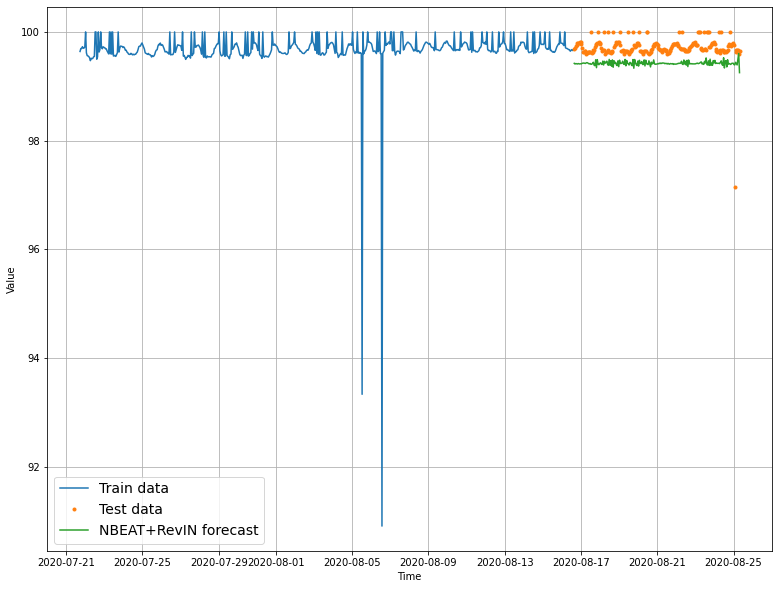

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
ensemble_median = np.median(ensemble_preds, axis=0)
offset = 0 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_train.index[offset:], values=y_train[offset:], label="Train data")
plot_time_series(timesteps=X_test.index[offset:], values=y_test[offset:], format = '.', start=offset, label="Test data")
plot_time_series(timesteps=X_test.index[offset:], values=ensemble_median[offset:], start=offset, label="NBEAT+RevIN forecast");

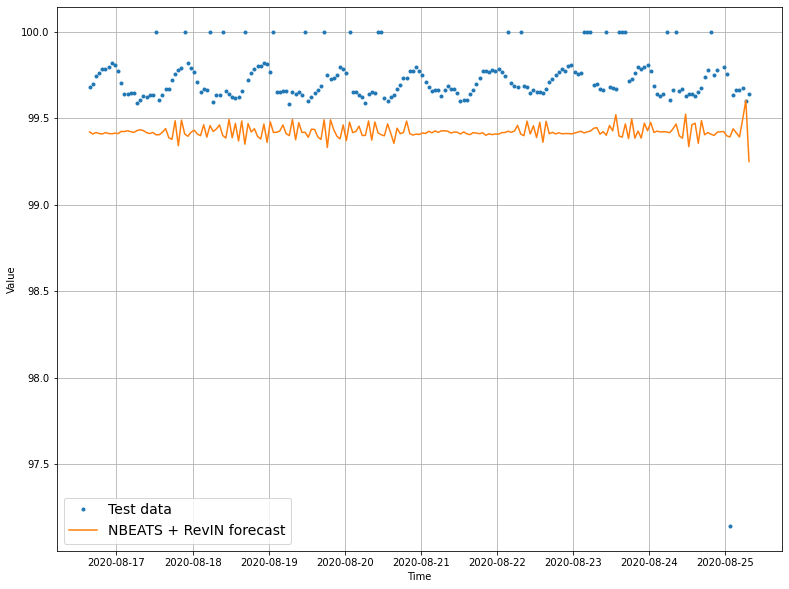

In [25]:
plt.figure(figsize=(13, 10))
offset = 0 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_test.index[offset:], values=y_test[offset:], format = ".", start=offset, label="Test data")
plot_time_series(timesteps=X_test.index[offset:], values=ensemble_median[offset:], format="-", start=offset, label="NBEATS + RevIN forecast");

In [22]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 8 # how far to lookback
# Add windowed columns
df_nbeats = dataset50['46'].copy()
for win_size in range(WINDOW_SIZE):
    df_nbeats[f"value+{win_size+1}"] = df_nbeats["value"].shift(periods=win_size+1)
# Make features and labels
X = df_nbeats.dropna().drop("value", axis=1)
y = df_nbeats.dropna()["value"]

# Make train and test sets
split_size = int(len(X) * 0.75)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
print(len(X_train), len(y_train), len(X_test), len(y_test))

# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

624 624 208 208


(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [27]:
# Get list of trained ensemble models
model_46 = get_ensemble_models(key = '46', num_iter=5, num_epochs=1000)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 1431.50it/s]


Optimizing model by reducing: mae for 1000 epochs, model number: 0, window size: 7

Epoch 778: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 1093: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1193: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



 33%|███▎      | 1/3 [01:19<02:38, 79.13s/it]

100%|██████████| 8/8 [00:00<00:00, 1761.85it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 243: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 535: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 663: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 763: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 67%|██████▋   | 2/3 [02:14<01:05, 65.36s/it]

100%|██████████| 8/8 [00:00<00:00, 1644.50it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 595: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 867: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 978: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1078: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 2066.92it/s]

Optimizing model by reducing: mae for 1000 epochs, model number: 1, window size: 7



Epoch 153: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 442: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1179: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1292: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 1392: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



 33%|███▎      | 1/3 [01:40<03:21, 100.51s/it]

100%|██████████| 8/8 [00:00<00:00, 1315.45it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 285: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 720: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 862: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 962: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 67%|██████▋   | 2/3 [02:52<01:23, 83.67s/it] 

100%|██████████| 8/8 [00:00<00:00, 1768.54it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 336: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 815: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 915: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 1934.64it/s]

Optimizing model by reducing: mae for 1000 epochs, model number: 2, window size: 7



Epoch 190: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 444: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1821: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1932: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 2032: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



 33%|███▎      | 1/3 [02:06<04:12, 126.32s/it]

100%|██████████| 8/8 [00:00<00:00, 2106.37it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 236: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 532: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 667: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 767: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 67%|██████▋   | 2/3 [03:07<01:28, 88.17s/it] 

100%|██████████| 8/8 [00:00<00:00, 1908.24it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 311: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 693: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 831: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 931: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 2058.30it/s]

Optimizing model by reducing: mae for 1000 epochs, model number: 3, window size: 7



Epoch 181: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 445: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 606: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 706: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 33%|███▎      | 1/3 [00:53<01:47, 53.93s/it]

100%|██████████| 8/8 [00:00<00:00, 1657.91it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 214: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 639: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1062: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1162: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 67%|██████▋   | 2/3 [02:13<01:08, 68.84s/it]

100%|██████████| 8/8 [00:00<00:00, 1920.91it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 651: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 989: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1089: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 1928.75it/s]

Optimizing model by reducing: mae for 1000 epochs, model number: 4, window size: 7



Epoch 206: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 529: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1516: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1616: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 33%|███▎      | 1/3 [01:50<03:41, 110.91s/it]

100%|██████████| 8/8 [00:00<00:00, 1939.34it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 351: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 761: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1329: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1429: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 67%|██████▋   | 2/3 [03:26<01:41, 101.80s/it]

100%|██████████| 8/8 [00:00<00:00, 1757.51it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 291: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 698: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 830: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 930: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



100%|██████████| 5/5 [19:40<00:00, 236.03s/it]


In [28]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=model_46,
                                     data=test_dataset)
ensemble_preds

1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(15, 208), dtype=float32, numpy=
array([[ -732.67444,  -254.15503,  -298.92468, ...,  2979.351  ,
         2886.9966 ,  2382.935  ],
       [ 1575.281  ,  -302.70862, -1290.9196 , ...,  3631.8682 ,
         2798.14   ,   222.44385],
       [ 1485.0826 ,  -151.91492,  -301.00293, ...,  2907.351  ,
         3122.851  ,  1822.3826 ],
       ...,
       [  745.0339 ,   534.4745 ,   435.38165, ...,  3686.6768 ,
         3793.0918 ,  -218.40381],
       [ 1479.3644 ,   477.41052,  -131.3357 , ...,  3751.587  ,
         3301.8662 ,  4474.915  ],
       [ -591.0293 ,  -103.21179,  -660.3567 , ...,  3405.5469 ,
         1765.8324 ,  3443.664  ]], dtype=float32)>

In [29]:
import numpy as np
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results


{'mae': 236.73495,
 'mse': 108310.95,
 'rmse': 329.1063,
 'mape': 69.8281,
 'mase': 0.8075697}

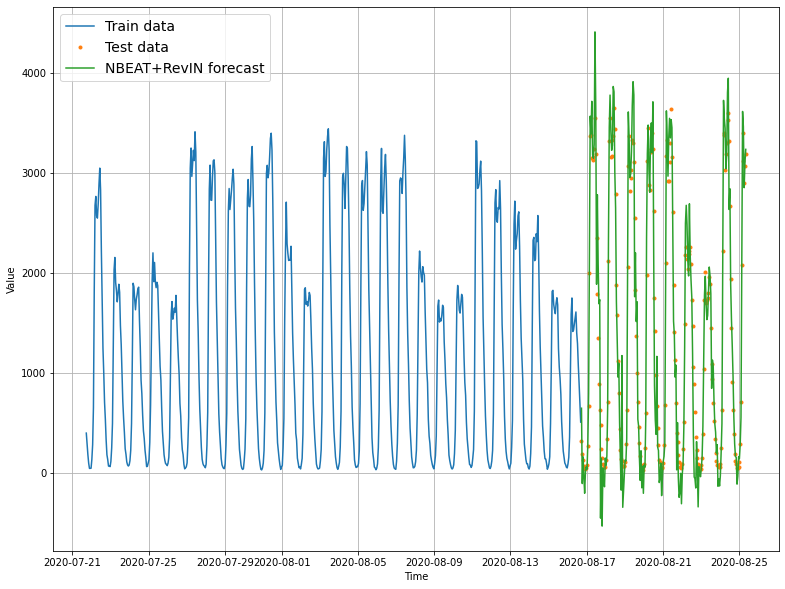

In [30]:

import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
ensemble_median = np.median(ensemble_preds, axis=0)
offset = 0 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_train.index[offset:], values=y_train[offset:], label="Train data")
plot_time_series(timesteps=X_test.index[offset:], values=y_test[offset:], format = '.', start=offset, label="Test data")
plot_time_series(timesteps=X_test.index[offset:], values=ensemble_median[offset:], start=offset, label="NBEAT+RevIN forecast");


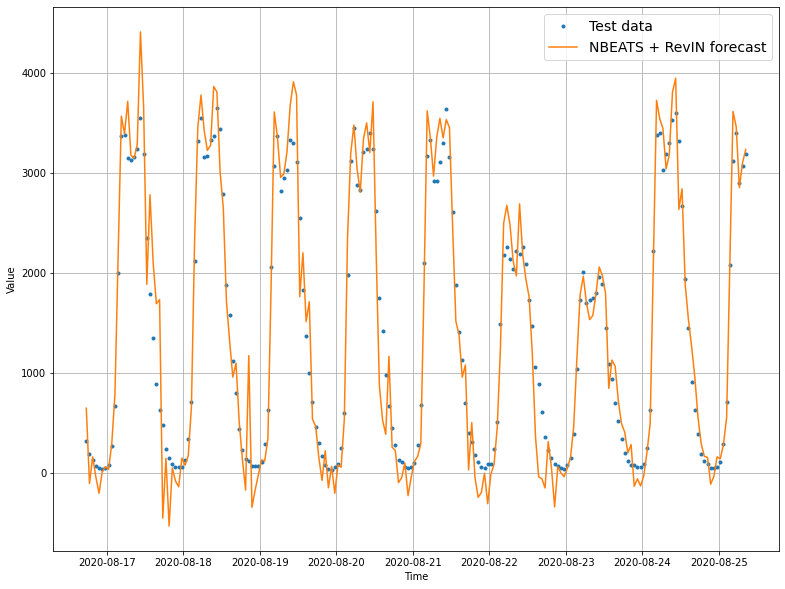

In [31]:
plt.figure(figsize=(13, 10))
offset = 0 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_test.index[offset:], values=y_test[offset:], format = ".", start=offset, label="Test data")
plot_time_series(timesteps=X_test.index[offset:], values=ensemble_median[offset:], format="-", start=offset, label="NBEATS + RevIN forecast");

In [32]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 8 # how far to lookback
# Add windowed columns
df_nbeats = dataset50['48'].copy()
for win_size in range(WINDOW_SIZE):
    df_nbeats[f"value+{win_size+1}"] = df_nbeats["value"].shift(periods=win_size+1)
# Make features and labels
X = df_nbeats.dropna().drop("value", axis=1)
y = df_nbeats.dropna()["value"]

# Make train and test sets
split_size = int(len(X) * 0.75)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
print(len(X_train), len(y_train), len(X_test), len(y_test))

# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

617 617 206 206


(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [33]:

# Get list of trained ensemble models
model_48 = get_ensemble_models(key = '48', num_iter=5, num_epochs=1000)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 1675.38it/s]


Optimizing model by reducing: mae for 1000 epochs, model number: 0, window size: 7

Epoch 357: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 614: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1803: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1945: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 2045: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



 33%|███▎      | 1/3 [02:31<05:03, 151.73s/it]

100%|██████████| 8/8 [00:00<00:00, 1926.31it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 172: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 426: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1576: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1725: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 1825: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



 67%|██████▋   | 2/3 [04:47<02:22, 142.14s/it]

100%|██████████| 8/8 [00:00<00:00, 1928.97it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 217: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 602: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1631: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1731: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 1970.31it/s]

Optimizing model by reducing: mae for 1000 epochs, model number: 1, window size: 7



Epoch 158: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 426: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 2039: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 2179: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 2279: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



 33%|███▎      | 1/3 [02:35<05:10, 155.13s/it]

100%|██████████| 8/8 [00:00<00:00, 1918.05it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 210: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 497: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 597: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



 67%|██████▋   | 2/3 [03:25<01:33, 93.53s/it] 

100%|██████████| 8/8 [00:00<00:00, 2008.65it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 202: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 546: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1909: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 2039: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 2139: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 1959.73it/s]

Optimizing model by reducing: mae for 1000 epochs, model number: 2, window size: 7



Epoch 385: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 751: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 888: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 988: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 33%|███▎      | 1/3 [01:14<02:29, 74.55s/it]

100%|██████████| 8/8 [00:00<00:00, 1739.74it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 153: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 516: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 953: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1053: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 67%|██████▋   | 2/3 [02:31<01:15, 75.81s/it]

100%|██████████| 8/8 [00:00<00:00, 1803.90it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 612: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 1247: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1347: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 1946.76it/s]

Optimizing model by reducing: mae for 1000 epochs, model number: 3, window size: 7



Epoch 747: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 1238: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1853: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1953: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 33%|███▎      | 1/3 [02:13<04:26, 133.35s/it]

100%|██████████| 8/8 [00:00<00:00, 2000.86it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 245: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 552: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 689: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 789: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



 67%|██████▋   | 2/3 [03:12<01:29, 89.42s/it] 

100%|██████████| 8/8 [00:00<00:00, 1827.78it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 287: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 721: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 2308: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 2408: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.



  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 1979.15it/s]

Optimizing model by reducing: mae for 1000 epochs, model number: 4, window size: 7



Epoch 419: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 963: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1891: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 2003: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 2103: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



 33%|███▎      | 1/3 [02:25<04:50, 145.24s/it]

100%|██████████| 8/8 [00:00<00:00, 1926.09it/s]

Optimizing model by reducing: mse for 1000 epochs, model number: 28, window size: 7



Epoch 159: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 418: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 1593: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 1727: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 1827: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.



 67%|██████▋   | 2/3 [04:36<02:17, 137.19s/it]

100%|██████████| 8/8 [00:00<00:00, 1947.22it/s]

Optimizing model by reducing: mape for 1000 epochs, model number: 28, window size: 7



Epoch 186: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 487: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 587: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.



100%|██████████| 5/5 [28:09<00:00, 337.83s/it]


In [35]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=model_48,
                                     data=test_dataset)
ensemble_preds

1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(15, 206), dtype=float32, numpy=
array([[  3957.0723 ,  17697.059  ,   2987.293  , ...,  14425.326  ,
         32318.635  ,  16174.156  ],
       [ -6189.6816 ,   9941.705  ,  17620.855  , ...,  29694.959  ,
           413.07617,  12557.542  ],
       [ 20853.51   ,   4247.093  ,  15672.736  , ...,   7694.6963 ,
          7273.93   ,  12305.946  ],
       ...,
       [ 15076.016  ,  -4510.371  ,   9675.547  , ...,   -586.5869 ,
         23709.934  ,  -1813.2109 ],
       [ 16285.821  ,  16634.81   ,   9639.918  , ..., -10891.281  ,
         15838.274  ,  15091.822  ],
       [ 15152.8125 ,  12898.721  ,  37657.39   , ...,  -4695.1016 ,
         26441.297  ,  -1896.2617 ]], dtype=float32)>

In [36]:
import numpy as np
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

{'mae': 7045.1665,
 'mse': 236219950.0,
 'rmse': 15369.448,
 'mape': 48.01327,
 'mase': 6.2121615}

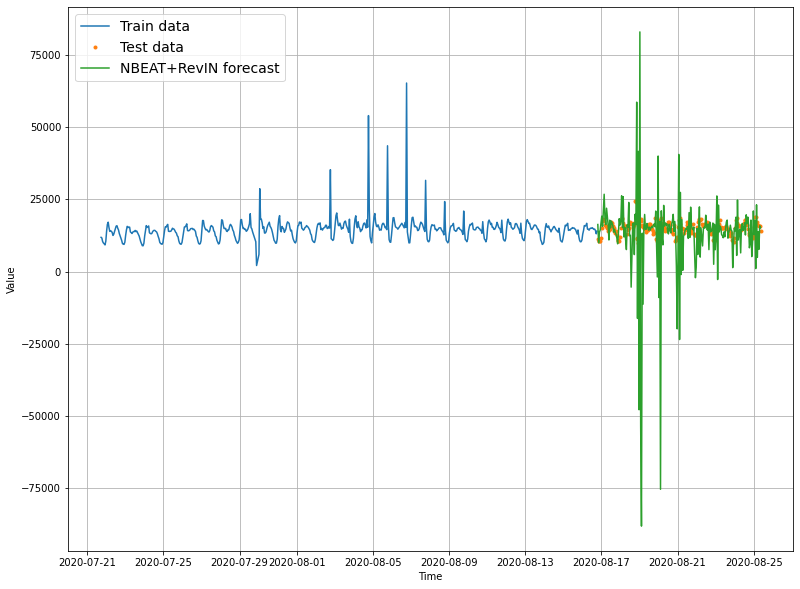

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
ensemble_median = np.median(ensemble_preds, axis=0)
offset = 0 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_train.index[offset:], values=y_train[offset:], label="Train data")
plot_time_series(timesteps=X_test.index[offset:], values=y_test[offset:], format = '.', start=offset, label="Test data")
plot_time_series(timesteps=X_test.index[offset:], values=ensemble_median[offset:], start=offset, label="NBEAT+RevIN forecast");

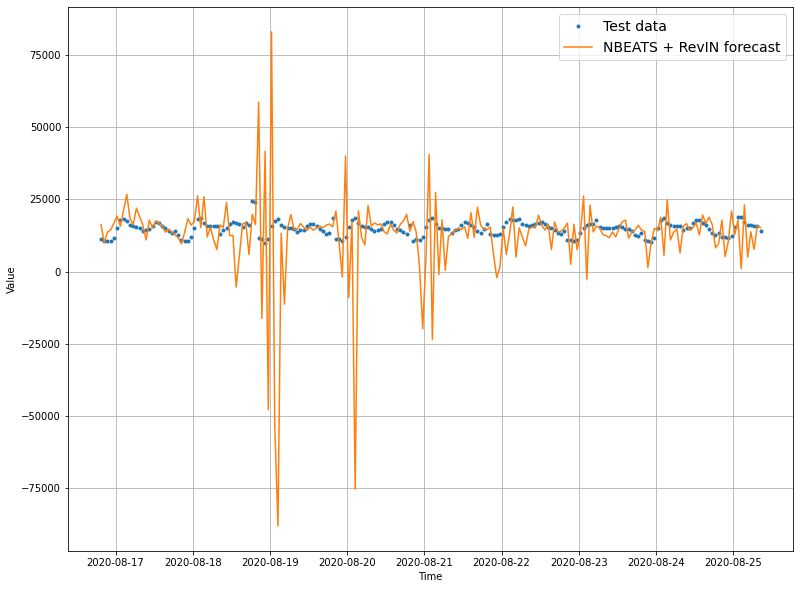

In [38]:
plt.figure(figsize=(13, 10))
offset = 0 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_test.index[offset:], values=y_test[offset:], format = ".", start=offset, label="Test data")
plot_time_series(timesteps=X_test.index[offset:], values=ensemble_median[offset:], format="-", start=offset, label="NBEATS + RevIN forecast");